In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import ta  
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.signal import argrelextrema
import pandas as pd
import numpy as np
import ta
from scipy.stats import skew, kurtosis

In [2]:
file_path = r"C:\Users\amirhossein\Desktop\project of master\btcusd_1-min_data (1).csv"

# Load data
df = pd.read_csv(file_path)

In [3]:
# Parse timestamp
if np.issubdtype(df['Timestamp'].dtype, np.number):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
else:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df = df.set_index('Timestamp')

# Resample to 15-minute intervals
df = df.resample('15min').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
}).dropna()

In [4]:
df['Close'] = df['Close'].ffill()

# --- Price-based features ---
df['Return_pct'] = df['Close'].pct_change()
df['Log_return'] = np.log(df['Close'] / df['Close'].shift(1))
df['SMA_10'] = df['Close'].rolling(10).mean()
df['SMA_50'] = df['Close'].rolling(50).mean()
df['EMA_10'] = df['Close'].ewm(span=10).mean()

# --- Volume-based features ---

# --- Technical indicators (from `ta` library) ---
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close']).rsi()
bb = ta.volatility.BollingerBands(close=df['Close'])
df['BB_high'] = bb.bollinger_hband()
df['BB_low'] = bb.bollinger_lband()
macd = ta.trend.MACD(close=df['Close'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()
df['Stoch_%K'] = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close']).stoch()
df['ATR'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close']).average_true_range()

# --- Statistical features ---
window = 20
df['Volatility'] = df['Log_return'].rolling(window).std()
df['Skewness'] = df['Log_return'].rolling(window).apply(skew)
df['Kurtosis'] = df['Log_return'].rolling(window).apply(kurtosis)
df['Autocorr'] = df['Log_return'].rolling(window).apply(lambda x: x.autocorr(lag=1))

# --- Time-based features ---
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Day'] = df.index.day
df['Is_weekend'] = (df['DayOfWeek'] >= 5).astype(int)

# --- Drop NaNs from feature creation ---
df = df.dropna()


In [5]:
# انتخاب ستون‌های اصلی
df = df[['Open', 'High', 'Low', 'Close']].copy()

df_15m = df.resample('15min').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
}).dropna()
df_15m['Close'] = df_15m['Close'].ffill()

df_15m['Return_pct'] = df_15m['Close'].pct_change()
df_15m['Log_return'] = np.log(df_15m['Close'] / df_15m['Close'].shift(1))
df_15m['SMA_10'] = df_15m['Close'].rolling(10).mean()
df_15m['SMA_50'] = df_15m['Close'].rolling(50).mean()
df_15m['EMA_10'] = df_15m['Close'].ewm(span=10).mean()

df_15m['RSI'] = ta.momentum.RSIIndicator(close=df_15m['Close']).rsi()
macd = ta.trend.MACD(close=df_15m['Close'])
df_15m['MACD'] = macd.macd()
df_15m['MACD_signal'] = macd.macd_signal()
df_15m['Stoch_%K'] = ta.momentum.StochasticOscillator(
    high=df_15m['High'], low=df_15m['Low'], close=df_15m['Close']).stoch()
df_15m['ATR'] = ta.volatility.AverageTrueRange(
    high=df_15m['High'], low=df_15m['Low'], close=df_15m['Close']).average_true_range()
bb = ta.volatility.BollingerBands(close=df_15m['Close'])
df_15m['BB_high'] = bb.bollinger_hband()
df_15m['BB_low'] = bb.bollinger_lband()

window = 20
df_15m['Volatility'] = df_15m['Log_return'].rolling(window).std()
df_15m['Skewness'] = df_15m['Log_return'].rolling(window).apply(skew)
df_15m['Kurtosis'] = df_15m['Log_return'].rolling(window).apply(kurtosis)
df_15m['Autocorr'] = df_15m['Log_return'].rolling(window).apply(lambda x: x.autocorr(lag=1))

df_15m['Hour'] = df_15m.index.hour
df_15m['DayOfWeek'] = df_15m.index.dayofweek
df_15m['Is_weekend'] = (df_15m['DayOfWeek'] >= 5).astype(int)

df_15m = df_15m.dropna()

def extract_higher_tf(df, rule, suffix):
    df_tf = df.resample(rule).agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last'
    }).dropna()
    df_tf = df_tf.rename(columns={col: f"{col}_{suffix}" for col in df_tf.columns})
    return df_tf

df_1h = extract_higher_tf(df, '1H', '1h')
df_4h = extract_higher_tf(df, '4H', '4h')

# merge درون df_15m
df_all = df_15m.join(df_1h, how='left').join(df_4h, how='left')
df_all = df_all.dropna()

# نمایش نهایی
print("✅ پیش‌پردازش کامل شد. شکل نهایی داده‌ها:")
display(df_all.tail())


C:\Users\amirhossein\AppData\Local\Temp\ipykernel_16664\1626429758.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_tf = df.resample(rule).agg({
C:\Users\amirhossein\AppData\Local\Temp\ipykernel_16664\1626429758.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_tf = df.resample(rule).agg({


✅ پیش‌پردازش کامل شد. شکل نهایی داده‌ها:


,Open,High,Low,Close,Return_pct,Log_return,SMA_10,SMA_50,EMA_10,RSI,...,DayOfWeek,Is_weekend,Open_1h,High_1h,Low_1h,Close_1h,Open_4h,High_4h,Low_4h,Close_4h
Timestamp,,,,,,,,,,,,,,,,,,,,,
2025-05-12 08:00:00,104477.0,104535.0,104085.0,104300.0,-0.001618,-0.001619,104540.1,104199.50,104533.853954,49.515982,...,0,0,104477.0,104741.0,104085.0,104621.0,104477.0,104741.0,103645.0,103776.0
2025-05-12 12:00:00,103753.0,103945.0,103739.0,103945.0,0.001629,0.001627,104274.6,104268.06,104217.150297,41.581782,...,0,0,103753.0,104132.0,103739.0,103887.0,103753.0,104618.0,102414.0,102537.0
2025-05-12 16:00:00,102531.0,102784.0,102487.0,102783.0,0.002399,0.002396,103140.2,104049.78,103065.428749,38.376832,...,0,0,102531.0,103078.0,102487.0,102859.0,102531.0,103095.0,100764.0,101838.0
2025-05-12 20:00:00,101833.0,101991.0,101763.0,101858.0,0.000196,0.000196,101772.7,103384.88,101907.947365,39.436292,...,0,0,101833.0,102899.0,101763.0,102681.0,101833.0,103133.0,101763.0,102796.0
2025-05-13 00:00:00,102796.0,102796.0,102553.0,102633.0,-0.001586,-0.001587,102787.3,102825.72,102739.848318,49.406238,...,1,0,102796.0,102796.0,102222.0,102271.0,102796.0,102796.0,102222.0,102271.0


In [6]:

def find_price_pivots(df, order=5):
    """
    شناسایی نقاط مینیمم و ماکسیمم محلی با window مشخص
    """
    local_min_idx = argrelextrema(df['Close'].values, np.less_equal, order=order)[0]
    local_max_idx = argrelextrema(df['Close'].values, np.greater_equal, order=order)[0]

    pivots = pd.DataFrame(index=df.index)
    pivots['pivot'] = np.nan
    pivots.loc[df.iloc[local_max_idx].index, 'pivot'] = df.iloc[local_max_idx]['Close']
    pivots.loc[df.iloc[local_min_idx].index, 'pivot'] = df.iloc[local_min_idx]['Close']

    return pivots


In [7]:
def detect_impulse_waves(df, pivots, fib_tolerance=0.2):
    """
    شناسایی الگوی 5 موجی بر اساس جهت، نسبت حرکت، تأیید RSI
    """
    labels = {}
    pivot_points = pivots.dropna()
    pivot_idx = pivot_points.index
    pivot_vals = pivot_points['pivot'].values

    i = 0
    while i + 4 < len(pivot_vals):
        p_idx = pivot_idx[i:i+5]
        p_vals = pivot_vals[i:i+5]

        # بررسی صعودی یا نزولی
        is_up = p_vals[0] < p_vals[1] > p_vals[2] < p_vals[3] > p_vals[4]
        is_down = p_vals[0] > p_vals[1] < p_vals[2] > p_vals[3] < p_vals[4]

        if is_up or is_down:
            # نسبت موج 3 به موج 1 > 1.5 (فیبوناچی)
            wave1 = abs(p_vals[1] - p_vals[0])
            wave3 = abs(p_vals[3] - p_vals[2])

            if wave3 > wave1 * (1.5 - fib_tolerance):
                # تأیید: RSI در موج 3 باید بالاتر از بقیه باشه (صعودی)
                rsi_3 = df.loc[p_idx[2], 'RSI']
                rsi_5 = df.loc[p_idx[4], 'RSI']
                if pd.notna(rsi_3) and pd.notna(rsi_5) and (rsi_3 > rsi_5):
                    for j, label in enumerate(['1','2','3','4','5']):
                        labels[p_idx[j]] = label
                    i += 5
                    continue
        i += 1
    return labels


In [8]:
# 1. استخراج پیوت‌ها
pivot_df = find_price_pivots(df_all, order=5)
df_all['Pivot'] = pivot_df['pivot']

# 2. تشخیص موج‌ها
wave_labels = detect_impulse_waves(df_all, df_all[['Pivot']].rename(columns={'Pivot': 'pivot'}))

# 3. اضافه کردن برچسب‌ها
df_all['Wave_Label'] = df_all.index.map(wave_labels).fillna('None')

# بررسی خروجی
print(df_all['Wave_Label'].value_counts())


Wave_Label
None    27366
1         293
2         293
3         293
4         293
5         293
Name: count, dtype: int64


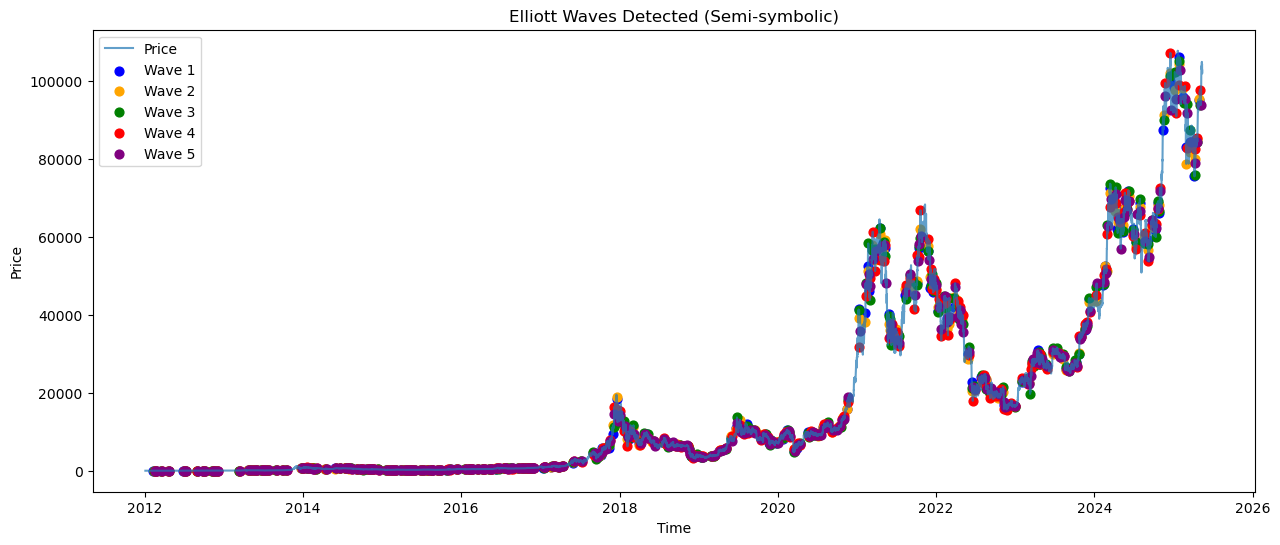

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.plot(df_all['Close'], label='Price', alpha=0.7)

colors = {'1':'blue','2':'orange','3':'green','4':'red','5':'purple'}
for label in ['1','2','3','4','5']:
    temp = df_all[df_all['Wave_Label'] == label]
    plt.scatter(temp.index, temp['Close'], label=f'Wave {label}', color=colors[label], s=40)

plt.title("Elliott Waves Detected (Semi-symbolic)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


In [10]:
df_wave = df_all[df_all['Wave_Label'].isin(['1','2','3','4','5'])].copy()
print(f"📊 تعداد رکوردهای لیبل‌دار موجی: {len(df_wave)}")

📊 تعداد رکوردهای لیبل‌دار موجی: 1465


In [11]:
from sklearn.preprocessing import MinMaxScaler

features = ['Close', 'SMA_10', 'EMA_10', 'RSI', 'MACD', 'ATR', 'Stoch_%K',
            'Volatility', 'Skewness', 'Kurtosis', 'Autocorr']

scaler = MinMaxScaler()
df_wave[features] = scaler.fit_transform(df_wave[features])


In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_wave['Wave_Label_Code'] = label_encoder.fit_transform(df_wave['Wave_Label'])  # 1→0, 2→1, ...


In [13]:
import numpy as np

def create_sequences(X, y, seq_len=20):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X, y = create_sequences(df_wave[features].values, df_wave['Wave_Label_Code'].values, seq_len=20)
print("✅ شکل نهایی داده‌های ورودی:", X.shape)


✅ شکل نهایی داده‌های ورودی: (1445, 20, 11)


In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, shuffle=False)
y_train = to_categorical(y_train_raw)
y_test = to_categorical(y_test_raw)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


c:\Users\amirhossein\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.1896 - loss: 1.6149 - val_accuracy: 0.1983 - val_loss: 1.6097
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1778 - loss: 1.6110 - val_accuracy: 0.2241 - val_loss: 1.6094
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2185 - loss: 1.6097 - val_accuracy: 0.1983 - val_loss: 1.6100
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1619 - loss: 1.6116 - val_accuracy: 0.2069 - val_loss: 1.6093
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1939 - loss: 1.6096 - val_accuracy: 0.1983 - val_loss: 1.6094
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1846 - loss: 1.6103 - val_accuracy: 0.1983 - val_loss: 1.6096
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.2061 - loss: 1.6100 - val_accuracy: 0.2155 - val_loss: 1.6094
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.1925 - loss: 1.6096 - val_accuracy: 0.1983 - v

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step


C:\Users\amirhossein\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


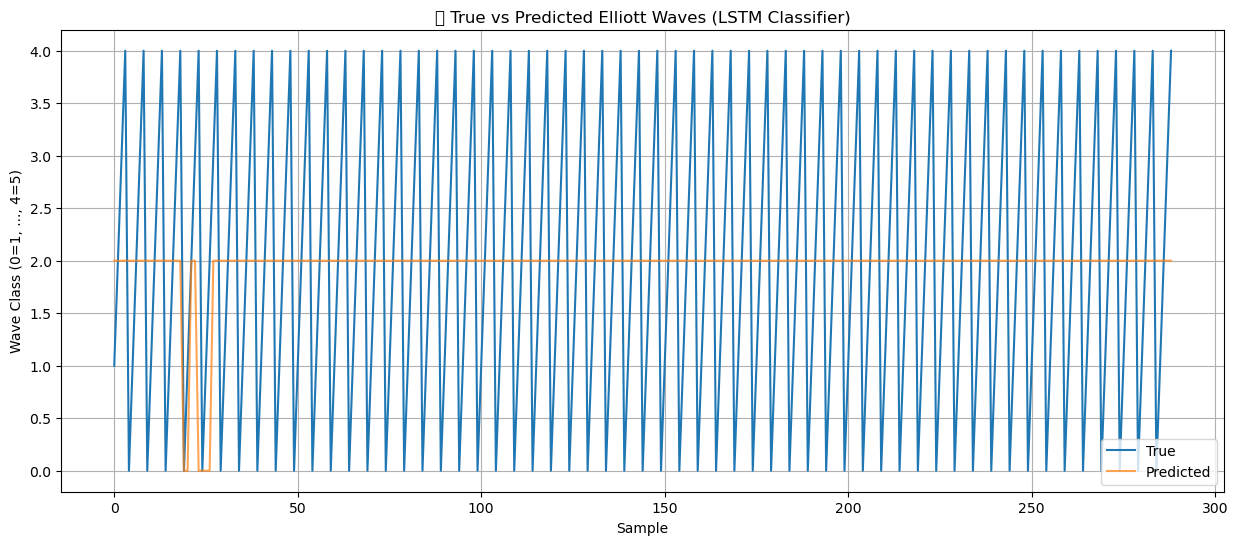

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# پیش‌بینی
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# مقایسه با واقعی
plt.figure(figsize=(15,6))
plt.plot(y_test_raw, label='True')
plt.plot(y_pred_labels, label='Predicted', alpha=0.7)
plt.legend()
plt.title('📊 True vs Predicted Elliott Waves (LSTM Classifier)')
plt.xlabel('Sample')
plt.ylabel('Wave Class (0=1, ..., 4=5)')
plt.grid()
plt.show()


In [17]:
def expand_wave_labels_to_ranges(df):
    df['Wave_Label_Full'] = 'None'
    wave_points = df[df['Wave_Label'].isin(['1','2','3','4','5'])]

    waves = wave_points.index.to_list()
    wave_vals = wave_points['Wave_Label'].to_list()

    for i in range(len(waves) - 1):
        start = waves[i]
        end = waves[i + 1]
        label = wave_vals[i]
        df.loc[start:end, 'Wave_Label_Full'] = label

    return df


In [18]:
df_all = expand_wave_labels_to_ranges(df_all)
print(df_all['Wave_Label_Full'].value_counts())

Wave_Label_Full
5       19340
3        2970
2        2270
4        2212
1        1896
None      143
Name: count, dtype: int64


In [19]:
df_all['Wave_Binary'] = df_all['Wave_Label_Full'].apply(lambda x: 'InWave' if x in ['1','2','3','4','5'] else 'NoWave')

In [20]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

features = ['Close', 'SMA_10', 'EMA_10', 'RSI', 'MACD', 'ATR', 'Stoch_%K']
df_all = df_all.dropna(subset=features + ['Wave_Binary'])

scaler = MinMaxScaler()
df_all[features] = scaler.fit_transform(df_all[features])

label_enc = LabelEncoder()
df_all['Wave_Binary_Code'] = label_enc.fit_transform(df_all['Wave_Binary'])  # InWave=1, NoWave=0


In [21]:
def create_sequences(X, y, seq_len=20):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X, y = create_sequences(df_all[features].values, df_all['Wave_Binary_Code'].values)


In [22]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # چون Binary هست
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


c:\Users\amirhossein\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.9753 - loss: 0.0901 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 2/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.9959 - loss: 0.0271 - val_accuracy: 1.0000 - val_loss: 0.0082
Epoch 3/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.9951 - loss: 0.0314 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 4/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9963 - loss: 0.0249 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 5/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9965 - loss: 0.0237 - val_accuracy: 1.0000 - val_loss: 0.0088
Epoch 6/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9954 - loss: 0.0297 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 7/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9957 - loss: 0.0278 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 8/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.9956 - loss: 0.0287 - 

181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step


C:\Users\amirhossein\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


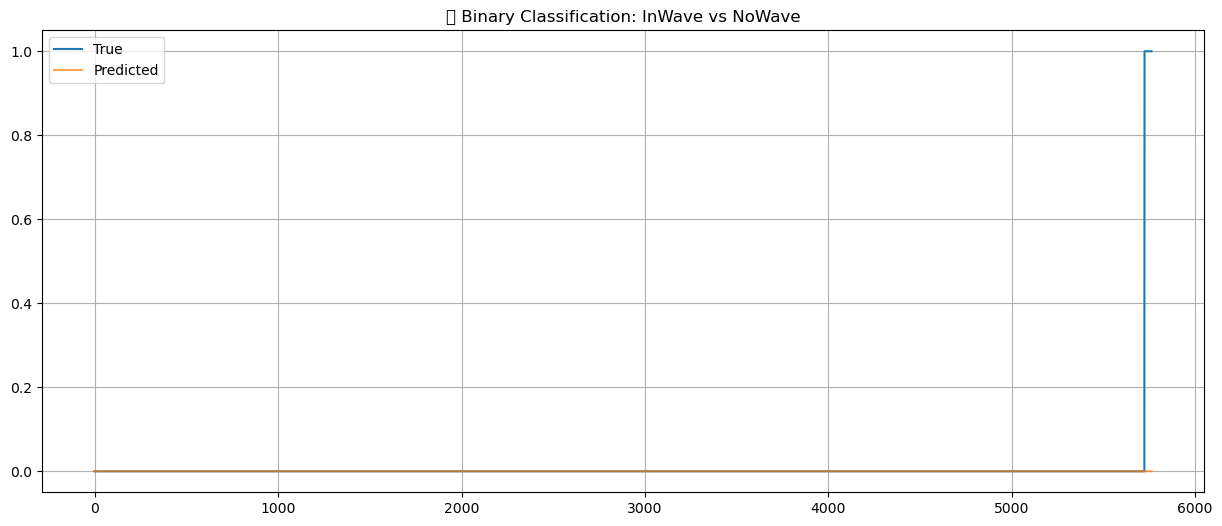

In [23]:
y_pred = model.predict(X_test).flatten()
y_pred_label = (y_pred > 0.5).astype(int)

import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(y_test, label='True')
plt.plot(y_pred_label, label='Predicted', alpha=0.7)
plt.title('📊 Binary Classification: InWave vs NoWave')
plt.legend()
plt.grid()
plt.show()


این مدل میگه همه شون داخل موج هستن که به دلیل این که تعداد نقاطی که داخل موج هستیم خیلی زیاده دقت بالا میره ولی فیکه

In [24]:
# تمام NoWave ها
nowave_df = df_all[df_all['Wave_Binary'] == 'NoWave']

# نمونه‌گیری تصادفی از InWave (مثلاً برابر با تعداد NoWave)
inwave_df = df_all[df_all['Wave_Binary'] == 'InWave'].sample(n=len(nowave_df), random_state=42)

# ترکیب و مرتب‌سازی
df_balanced = pd.concat([inwave_df, nowave_df]).sort_index()
print(df_balanced['Wave_Binary'].value_counts())


Wave_Binary
NoWave    143
InWave    143
Name: count, dtype: int64


In [25]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

features = ['Close', 'SMA_10', 'EMA_10', 'RSI', 'MACD', 'ATR', 'Stoch_%K']
df_balanced = df_balanced.dropna(subset=features + ['Wave_Binary'])

scaler = MinMaxScaler()
df_balanced[features] = scaler.fit_transform(df_balanced[features])

le = LabelEncoder()
df_balanced['Wave_Binary_Code'] = le.fit_transform(df_balanced['Wave_Binary'])  # NoWave=0, InWave=1


In [26]:
def create_sequences(X, y, seq_len=20):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X, y = create_sequences(df_balanced[features].values, df_balanced['Wave_Binary_Code'].values)


In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


c:\Users\amirhossein\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.5566 - loss: 0.6904 - val_accuracy: 1.0000 - val_loss: 0.5730
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.5596 - loss: 0.6829 - val_accuracy: 1.0000 - val_loss: 0.4915
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.5728 - loss: 0.6710 - val_accuracy: 1.0000 - val_loss: 0.4095
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.5476 - loss: 0.6657 - val_accuracy: 1.0000 - val_loss: 0.3162
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.5911 - loss: 0.6553 - val_accuracy: 1.0000 - val_loss: 0.1663
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.6102 - loss: 0.6162 - val_accuracy: 1.0000 - val_loss: 0.0734
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.6687 - loss: 0.6054 - val_accuracy: 1.0000 - val_loss: 0.0265
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.7173 - loss: 0.5500 - val_accuracy: 1.0000 - val_loss: 0.012

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step


C:\Users\amirhossein\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


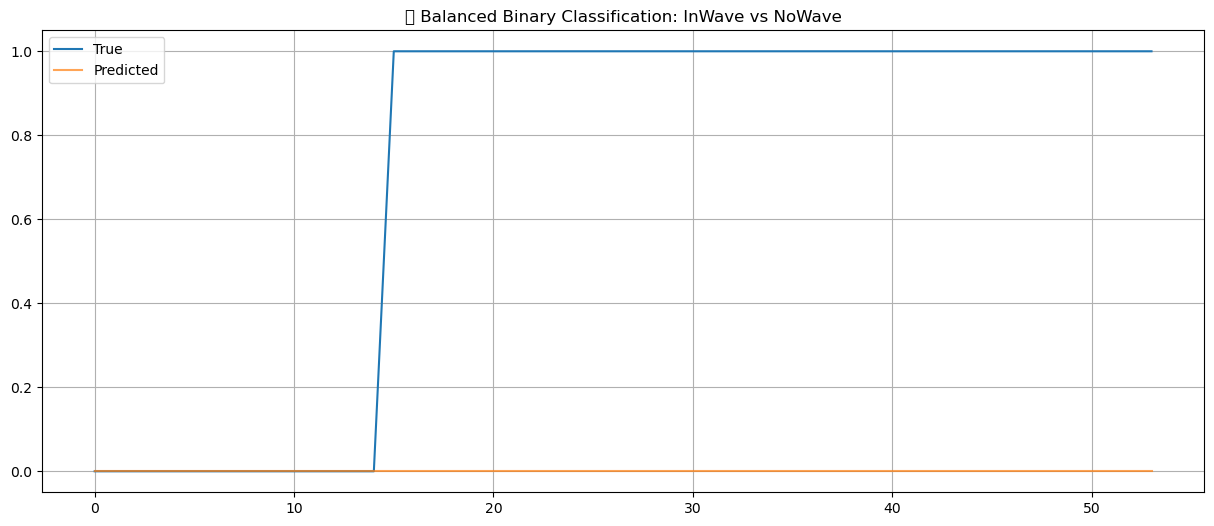

In [28]:
y_pred = model.predict(X_test).flatten()
y_pred_label = (y_pred > 0.5).astype(int)

import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(y_test, label='True')
plt.plot(y_pred_label, label='Predicted', alpha=0.7)
plt.title('✅ Balanced Binary Classification: InWave vs NoWave')
plt.legend()
plt.grid()
plt.show()


In [29]:
def map_final_wave_label(row):
    if row['Wave_Label_Full'] in ['1','2','3','4','5']:
        return int(row['Wave_Label_Full'])
    else:
        return 0  # NoWave

df_all['Wave_MultiClass'] = df_all.apply(map_final_wave_label, axis=1)
print(df_all['Wave_MultiClass'].value_counts())


Wave_MultiClass
5    19340
3     2970
2     2270
4     2212
1     1896
0      143
Name: count, dtype: int64


In [30]:
# حداکثر تعداد برای هر کلاس (مثلاً 500)
max_samples = 2000
df_samples = []

for cls in range(6):  # کلاس 0 تا 5
    cls_df = df_all[df_all['Wave_MultiClass'] == cls]
    sampled = cls_df.sample(n=min(len(cls_df), max_samples), random_state=42)
    df_samples.append(sampled)

df_balanced_multi = pd.concat(df_samples).sort_index()
print(df_balanced_multi['Wave_MultiClass'].value_counts())


Wave_MultiClass
2    2000
3    2000
4    2000
5    2000
1    1896
0     143
Name: count, dtype: int64


In [31]:
from sklearn.preprocessing import MinMaxScaler
features = ['Close', 'SMA_10', 'EMA_10', 'RSI', 'MACD', 'ATR', 'Stoch_%K']
df_balanced_multi = df_balanced_multi.dropna(subset=features + ['Wave_MultiClass'])

scaler = MinMaxScaler()
df_balanced_multi[features] = scaler.fit_transform(df_balanced_multi[features])


In [32]:
from tensorflow.keras.utils import to_categorical

X, y_raw = create_sequences(
    df_balanced_multi[features].values, 
    df_balanced_multi['Wave_MultiClass'].values, 
    seq_len=60
)

y = to_categorical(y_raw)  # One-hot encoding


In [33]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1)


c:\Users\amirhossein\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.1982 - loss: 1.6781 - val_accuracy: 0.1652 - val_loss: 1.6337
Epoch 2/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.2086 - loss: 1.6408 - val_accuracy: 0.1777 - val_loss: 1.6193
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.2101 - loss: 1.6377 - val_accuracy: 0.2403 - val_loss: 1.6083
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 32s 141ms/step - accuracy: 0.1993 - loss: 1.6396 - val_accuracy: 0.1915 - val_loss: 1.6187
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 156ms/step - accuracy: 0.2137 - loss: 1.6402 - val_accuracy: 0.1840 - val_loss: 1.6128
Epoch 6/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 58s 258ms/step - accuracy: 0.2086 - loss: 1.6367 - val_accuracy: 0.1777 - val_loss: 1.6200
Epoch 7/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 55s 136ms/step - accuracy: 0.2200 - loss: 1.6378 - val_accuracy: 0.2115 - val_loss: 1.6123
Epoch 8/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 29s 125ms/step - accuracy: 0.2169 - loss: 1.63

In [34]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
import numpy as np

# ---------------------------
# مرحله ۱: لیبل نهایی 0 تا 5
# ---------------------------
def map_final_wave_label(row):
    if row['Wave_Label_Full'] in ['1','2','3','4','5']:
        return int(row['Wave_Label_Full'])
    else:
        return 0  # NoWave

df_all['Wave_MultiClass'] = df_all.apply(map_final_wave_label, axis=1)

# ---------------------------
# مرحله ۲: نرمال‌سازی ویژگی‌ها
# ---------------------------
features = ['Close', 'SMA_10', 'EMA_10', 'RSI', 'MACD', 'ATR', 'Stoch_%K']
df_all = df_all.dropna(subset=features + ['Wave_MultiClass'])

scaler = MinMaxScaler()
df_all[features] = scaler.fit_transform(df_all[features])

# ---------------------------
# مرحله ۳: ساخت دیتاست دنباله‌ای با Voting
# ---------------------------
def make_sequence_classification_dataset(df, features, label_col='Wave_MultiClass', seq_len=20, threshold=0.7):
    Xs, ys = [], []
    y_seq = df[label_col].values
    X_vals = df[features].values

    for i in range(len(df) - seq_len):
        seq_x = X_vals[i:i+seq_len]
        seq_y = y_seq[i:i+seq_len]

        values, counts = np.unique(seq_y, return_counts=True)
        majority_class = values[np.argmax(counts)]
        if counts.max() / seq_len >= threshold:
            Xs.append(seq_x)
            ys.append(majority_class)
        else:
            Xs.append(seq_x)
            ys.append(0)  # NoWave

    return np.array(Xs), np.array(ys)

X, y_raw = make_sequence_classification_dataset(df_all, features, 'Wave_MultiClass', seq_len=20, threshold=0.7)
y = to_categorical(y_raw)


In [35]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1)


c:\Users\amirhossein\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
649/649 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.5790 - loss: 0.9922 - val_accuracy: 0.5202 - val_loss: 1.0038
Epoch 2/15
649/649 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.6145 - loss: 0.8902 - val_accuracy: 0.5202 - val_loss: 1.0130
Epoch 3/15
649/649 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.6087 - loss: 0.8911 - val_accuracy: 0.5202 - val_loss: 0.9722
Epoch 4/15
649/649 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.6190 - loss: 0.8791 - val_accuracy: 0.5202 - val_loss: 0.9857
Epoch 5/15
649/649 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6172 - loss: 0.8858 - val_accuracy: 0.5202 - val_loss: 0.9858
Epoch 6/15
649/649 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6041 - loss: 0.8910 - val_accuracy: 0.5202 - val_loss: 0.9900
Epoch 7/15
649/649 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6040 - loss: 0.8869 - val_accuracy: 0.5202 - val_loss: 0.9950
Epoch 8/15
649/649 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6081 - loss: 0.8909 - va

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


C:\Users\amirhossein\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


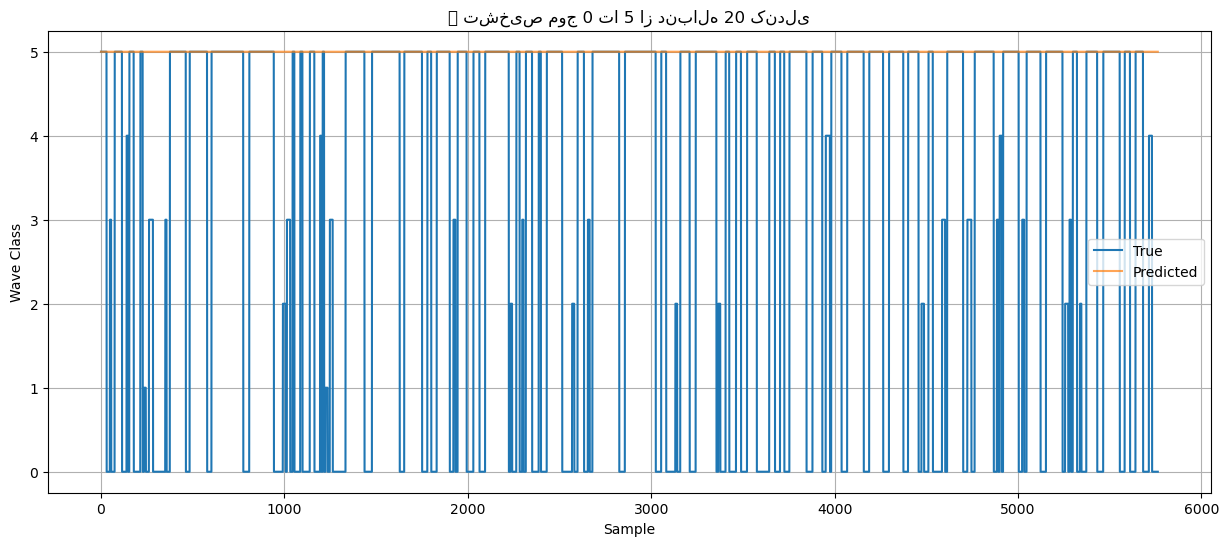

In [36]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(y_true_labels, label='True')
plt.plot(y_pred_labels, label='Predicted', alpha=0.7)
plt.title('📊 تشخیص موج 0 تا 5 از دنباله 20 کندلی')
plt.ylabel('Wave Class')
plt.xlabel('Sample')
plt.legend()
plt.grid()
plt.show()


In [37]:
from sklearn.utils import class_weight

# لیبل نهایی 0 تا 5
def map_final_wave_label(row):
    if row['Wave_Label_Full'] in ['1','2','3','4','5']:
        return int(row['Wave_Label_Full'])
    else:
        return 0  # NoWave

df_all['Wave_MultiClass'] = df_all.apply(map_final_wave_label, axis=1)

# تعادل دستی بین کلاس‌ها
max_per_class = 1500
dfs = []

for cls in df_all['Wave_MultiClass'].unique():
    subset = df_all[df_all['Wave_MultiClass'] == cls]
    dfs.append(subset.sample(n=min(len(subset), max_per_class), random_state=42))

df_balanced = pd.concat(dfs).sort_index()


In [38]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

features = ['Close', 'SMA_10', 'EMA_10', 'RSI', 'MACD', 'ATR', 'Stoch_%K']
df_balanced = df_balanced.dropna(subset=features + ['Wave_MultiClass'])

scaler = MinMaxScaler()
df_balanced[features] = scaler.fit_transform(df_balanced[features])

def make_sequence_classification_dataset(df, features, label_col='Wave_MultiClass', seq_len=20, threshold=0.7):
    Xs, ys = [], []
    y_seq = df[label_col].values
    X_vals = df[features].values

    for i in range(len(df) - seq_len):
        seq_x = X_vals[i:i+seq_len]
        seq_y = y_seq[i:i+seq_len]

        values, counts = np.unique(seq_y, return_counts=True)
        majority_class = values[np.argmax(counts)]
        if counts.max() / seq_len >= threshold:
            Xs.append(seq_x)
            ys.append(majority_class)
        else:
            Xs.append(seq_x)
            ys.append(0)  # NoWave

    return np.array(Xs), np.array(ys)

X, y_raw = make_sequence_classification_dataset(df_balanced, features, 'Wave_MultiClass', seq_len=20, threshold=0.7)
y = to_categorical(y_raw)


In [39]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_raw),
    y=y_raw
)
class_weights = dict(enumerate(class_weights))


In [40]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, class_weight=class_weights)


Epoch 1/20


c:\Users\amirhossein\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.0870 - loss: 1.6460 - val_accuracy: 0.0115 - val_loss: 1.7018
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.0625 - loss: 1.6288 - val_accuracy: 0.0115 - val_loss: 1.6530
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.0999 - loss: 1.6390 - val_accuracy: 0.7590 - val_loss: 0.9345
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.1205 - loss: 1.6958 - val_accuracy: 0.5377 - val_loss: 1.1271
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.0618 - loss: 1.7415 - val_accuracy: 0.7393 - val_loss: 0.7520
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.1106 - loss: 1.6096 - val_accuracy: 0.5311 - val_loss: 1.1412
Epoch 7/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.0845 - loss: 1.7031 - val_accuracy: 0.2885 - val_loss: 1.2850
Epoch 8/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.1038 - loss: 1.4829 - val_accuracy: 0.737

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


C:\Users\amirhossein\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


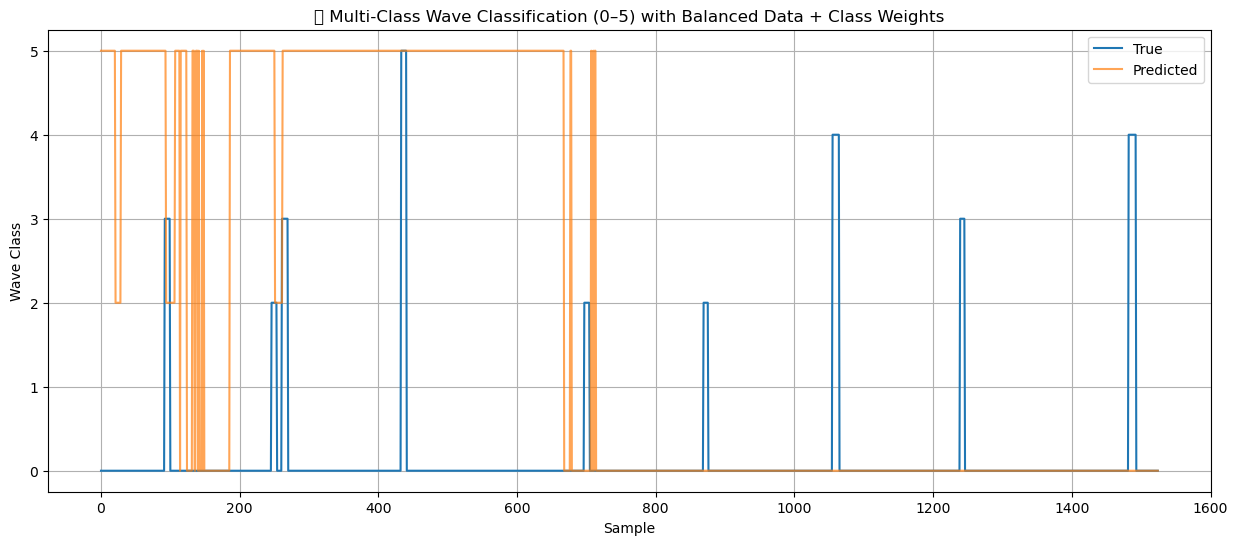

In [41]:
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

plt.figure(figsize=(15,6))
plt.plot(y_true_labels, label='True')
plt.plot(y_pred_labels, label='Predicted', alpha=0.7)
plt.title('🔁 Multi-Class Wave Classification (0–5) with Balanced Data + Class Weights')
plt.ylabel('Wave Class')
plt.xlabel('Sample')
plt.legend()
plt.grid()
plt.show()


## CONVD1D + BIDIRECTIONAL LSTM

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    BatchNormalization(),

    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),

    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.2),
    
    Dense(y.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1, class_weight=class_weights)


c:\Users\amirhossein\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.1826 - loss: 1.6082 - val_accuracy: 0.0492 - val_loss: 1.4162
Epoch 2/25
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.1268 - loss: 1.4907 - val_accuracy: 0.0377 - val_loss: 1.4571
Epoch 3/25
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.2034 - loss: 1.1712 - val_accuracy: 0.0508 - val_loss: 1.1329
Epoch 4/25
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.2290 - loss: 1.2201 - val_accuracy: 0.2623 - val_loss: 1.2337
Epoch 5/25
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.2671 - loss: 0.8979 - val_accuracy: 0.2967 - val_loss: 1.2117
Epoch 6/25
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.2851 - loss: 0.7629 - val_accuracy: 0.1230 - val_loss: 1.2565
Epoch 7/25
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3361 - loss: 0.5973 - val_accuracy: 0.5541 - val_loss: 1.0199
Epoch 8/25
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4577 - loss: 0.3852 - val_acc

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


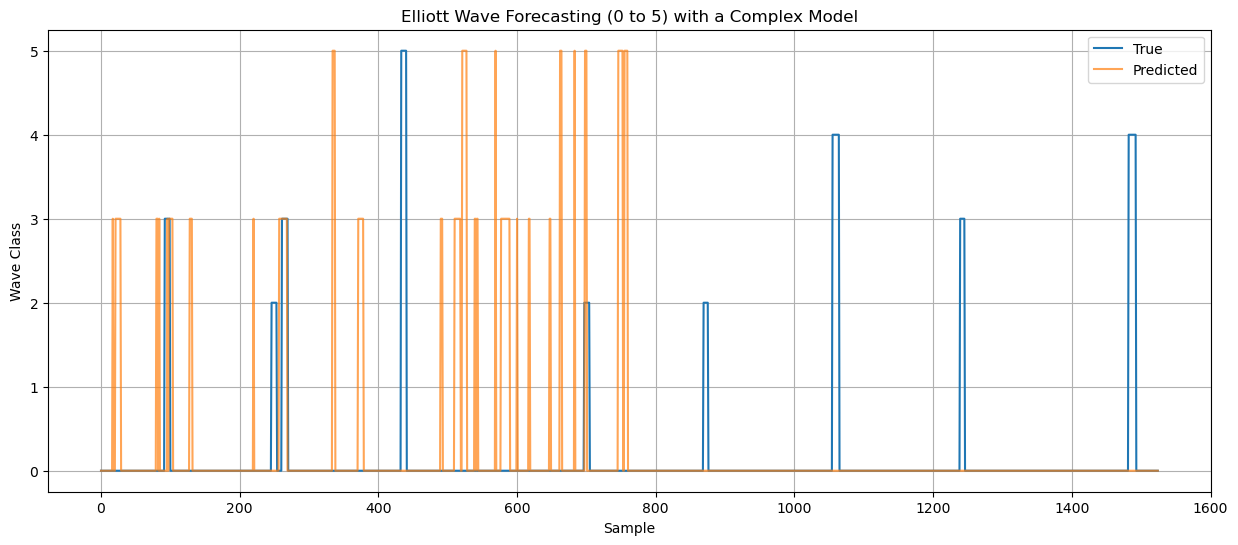

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# predict
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# plot
plt.figure(figsize=(15,6))
plt.plot(y_true_labels, label='True')
plt.plot(y_pred_labels, label='Predicted', alpha=0.7)
plt.title('Elliott Wave Forecasting (0 to 5) with a Complex Model')
plt.ylabel('Wave Class')
plt.xlabel('Sample')
plt.legend()
plt.grid()
plt.show()


# predict price

## LSTM

In [44]:
# فقط داده‌های دارای موج (کلاس 1 تا 5)
df_wave = df_all[df_all['Wave_MultiClass'] != 0].copy()

# شناسایی پایان موج‌ها (تغییر کلاس)
df_wave['Next_Label'] = df_wave['Wave_MultiClass'].shift(-1)
df_wave['Wave_End'] = df_wave['Wave_MultiClass'] != df_wave['Next_Label']

# جمع‌کردن Target Price: قیمت بسته شدن در آخر موج فعلی
targets = []
end_prices = []
seq_len = 20

for i in range(len(df_wave) - seq_len):
    window = df_wave.iloc[i:i+seq_len]
    current_class = window['Wave_MultiClass'].values[-1]
    
    # پیدا کردن پایان همین موج
    future = df_wave.iloc[i+seq_len:]
    same_wave = future[future['Wave_MultiClass'] == current_class]
    if not same_wave.empty:
        end_idx = same_wave[same_wave['Wave_End']].index.min()
        if pd.notna(end_idx):
            price_target = df_wave.loc[end_idx]['Close']
            end_prices.append(price_target)
            targets.append(window[features].values)


In [45]:
X_reg = np.array(targets)
y_price = np.array(end_prices)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_price, test_size=0.2, shuffle=False)


In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model_price = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1)  # خروجی تک مقداری (قیمت هدف)
])

model_price.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_price.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20


c:\Users\amirhossein\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


645/645 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.0013 - mae: 0.0192 - val_loss: 0.0017 - val_mae: 0.0332
Epoch 2/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - loss: 4.5735e-04 - mae: 0.0115 - val_loss: 0.0046 - val_mae: 0.0575
Epoch 3/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - loss: 3.8845e-04 - mae: 0.0100 - val_loss: 0.0048 - val_mae: 0.0597
Epoch 4/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 3.5759e-04 - mae: 0.0098 - val_loss: 0.0071 - val_mae: 0.0747
Epoch 5/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 3.3903e-04 - mae: 0.0099 - val_loss: 0.0064 - val_mae: 0.0635
Epoch 6/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 3.3283e-04 - mae: 0.0097 - val_loss: 0.0059 - val_mae: 0.0650
Epoch 7/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 2.9389e-04 - mae: 0.0091 - val_loss: 0.0075 - val_mae: 0.0728
Epoch 8/20
645/645 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 3.0828e-04 - mae: 0.0090 - val_loss: 0.0088 - val_mae: 0.0801
Epoch 9/20
645/645 ━━━━

180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


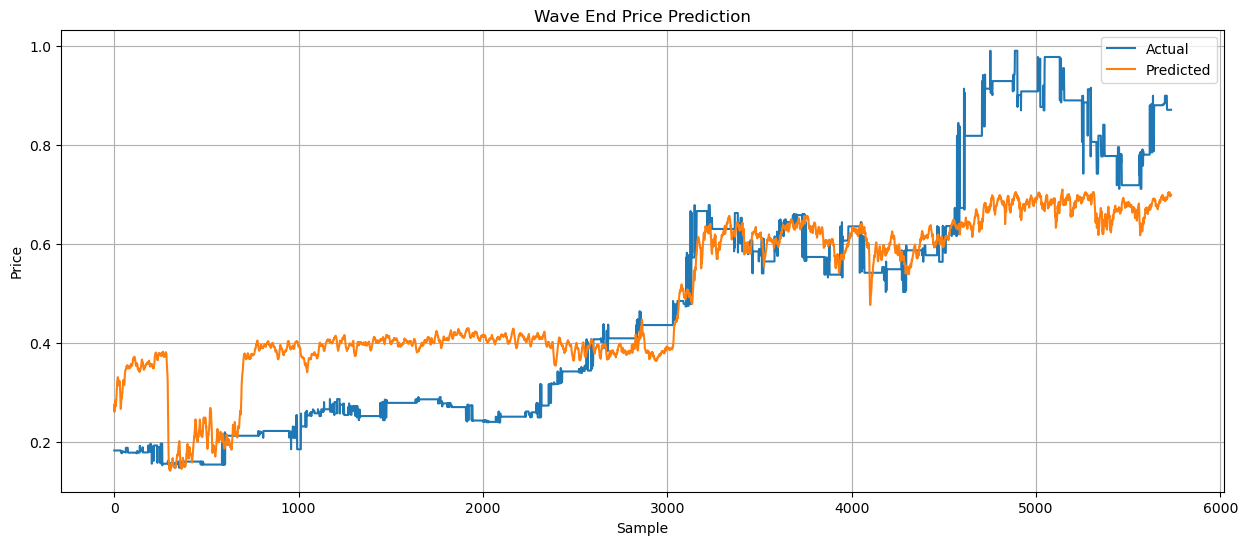

In [47]:
y_pred_price = model_price.predict(X_test)

plt.figure(figsize=(15,6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_price, label='Predicted')
plt.title('Wave End Price Prediction')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


## CONV1D + LSTM

In [48]:
import tensorflow as tf
from keras.metrics import Metric

class RegressionAccuracy(Metric):
    def __init__(self, threshold=0.05, name='accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.total = self.add_weight(name='total', initializer='zeros')
        self.correct = self.add_weight(name='correct', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        error = tf.math.abs((y_true - y_pred) / tf.math.maximum(tf.math.abs(y_true), tf.keras.backend.epsilon()))
        matches = tf.cast(error < self.threshold, dtype=tf.float32)
        self.correct.assign_add(tf.reduce_sum(matches))
        self.total.assign_add(tf.cast(tf.shape(y_true)[0], dtype=tf.float32))

    def result(self):
        return self.correct / self.total

    def reset_states(self):
        self.total.assign(0.0)
        self.correct.assign(0.0)


In [49]:
from keras.models import Sequential
from keras.layers import Input, Conv1D, LSTM, Dense, Dropout, LayerNormalization

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    LayerNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),

    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])


In [50]:
model.compile(
    optimizer='adam',
    loss='mse',
)

In [51]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - loss: 0.0029 - val_loss: 0.0366
Epoch 2/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - loss: 9.1270e-04 - val_loss: 0.0248
Epoch 3/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - loss: 7.8090e-04 - val_loss: 0.0299
Epoch 4/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - loss: 6.4592e-04 - val_loss: 0.0254
Epoch 5/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 6.2289e-04 - val_loss: 0.0282
Epoch 6/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 5.9115e-04 - val_loss: 0.0300
Epoch 7/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 5.7834e-04 - val_loss: 0.0298
Epoch 8/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 5.2212e-04 - val_loss: 0.0338
Epoch 9/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 5.4313e-04 - val_loss: 0.0364
Epoch 10/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - loss: 4.8032e-04 - val_loss: 0.0375
Epoch 11/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - loss: 4.8002e-04 - val_los

## Bidirectional Lstm

In [52]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam

# ایجاد مدل
model = Sequential()

# لایه‌ی Bidirectional LSTM
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # جلوگیری از overfitting

# لایه‌ی LSTM اضافی برای پردازش بهتر داده‌ها
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))

# لایه‌ی خروجی
model.add(Dense(1))

# کامپایل مدل
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# خلاصه مدل
model.summary()

# آموزش مدل
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# ارزیابی عملکرد مدل
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")


c:\Users\amirhossein\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 20, 128)        │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,809 (530.50 KB)

 Trainable params: 135,809 (530.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.0022 - mae: 0.0271 - val_loss: 0.0050 - val_mae: 0.0455
Epoch 2/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 7.5545e-04 - mae: 0.0155 - val_loss: 0.0072 - val_mae: 0.0558
Epoch 3/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - loss: 7.1595e-04 - mae: 0.0145 - val_loss: 0.0031 - val_mae: 0.0387
Epoch 4/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - loss: 6.9664e-04 - mae: 0.0145 - val_loss: 0.0050 - val_mae: 0.0448
Epoch 5/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - loss: 7.1340e-04 - mae: 0.0138 - val_loss: 0.0070 - val_mae: 0.0535
Epoch 6/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 7.1651e-04 - mae: 0.0139 - val_loss: 0.0058 - val_mae: 0.0475
Epoch 7/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 6.4258e-04 - mae: 0.0129 - val_loss: 0.0082 - val_mae: 0.0572
Epoch 8/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 6.2498e-04 - mae: 0.0128 - val_loss: 0.0101 - val_mae: 0.0636
Epoch 9/30
7

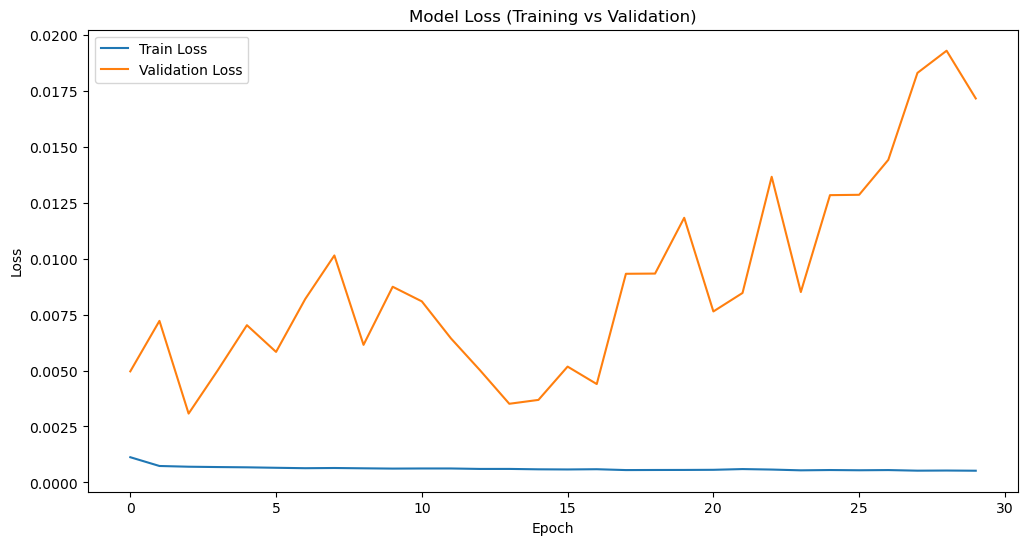

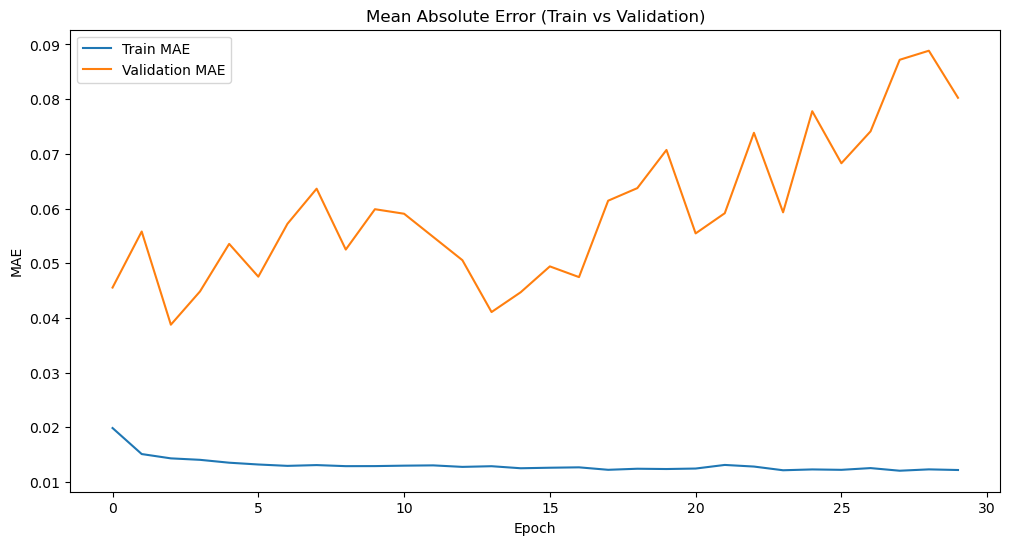

In [53]:
import matplotlib.pyplot as plt

# نمودار loss برای آموزش و اعتبارسنجی
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# نمودار MAE برای آموزش و اعتبارسنجی
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (Train vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()



Epoch 1/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.0033 - mae: 0.0251 - val_loss: 0.0050 - val_mae: 0.0467
Epoch 2/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 5.8968e-04 - mae: 0.0124 - val_loss: 0.0050 - val_mae: 0.0483
Epoch 3/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 5.2305e-04 - mae: 0.0116 - val_loss: 0.0039 - val_mae: 0.0428
Epoch 4/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 5.5114e-04 - mae: 0.0117 - val_loss: 0.0029 - val_mae: 0.0407
Epoch 5/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 4.8354e-04 - mae: 0.0109 - val_loss: 0.0034 - val_mae: 0.0429
Epoch 6/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 5.1688e-04 - mae: 0.0112 - val_loss: 0.0064 - val_mae: 0.0569
Epoch 7/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 4.7158e-04 - mae: 0.0106 - val_loss: 0.0051 - val_mae: 0.0514
Epoch 8/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 4.8108e-04 - mae: 0.0107 - val_loss: 0.0026 - val_mae: 0.0359
Epoch 9/30
717/7

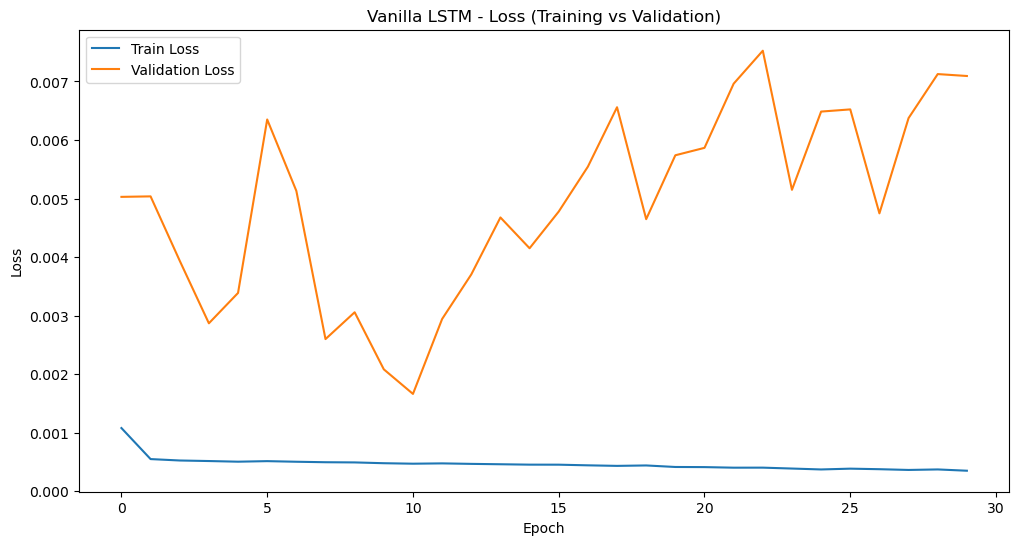

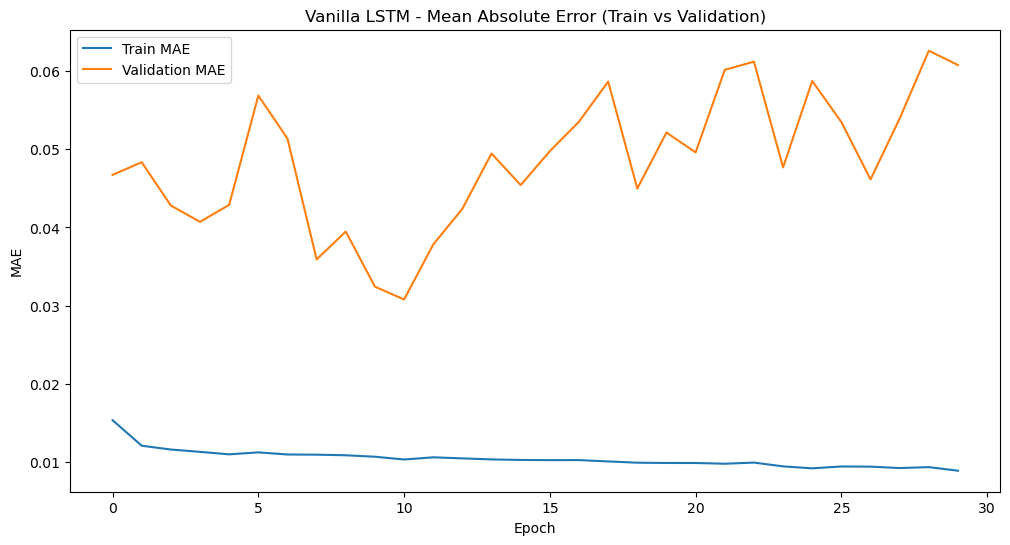

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# تعریف مدل Vanilla LSTM
model_vanilla = Sequential()
model_vanilla.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_vanilla.add(Dense(32, activation='relu'))
model_vanilla.add(Dense(1))

# کامپایل مدل با استفاده از Adam optimizer و MAE به عنوان متریک
model_vanilla.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])

# آموزش مدل
history_vanilla = model_vanilla.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# نمایش نتایج
print("Test Loss:", model_vanilla.evaluate(X_test, y_test)[0])
print("Test MAE:", model_vanilla.evaluate(X_test, y_test)[1])

# نمودار Loss (آموزش و اعتبارسنجی)
plt.figure(figsize=(12, 6))
plt.plot(history_vanilla.history['loss'], label='Train Loss')
plt.plot(history_vanilla.history['val_loss'], label='Validation Loss')
plt.title('Vanilla LSTM - Loss (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# نمودار MAE (آموزش و اعتبارسنجی)
plt.figure(figsize=(12, 6))
plt.plot(history_vanilla.history['mae'], label='Train MAE')
plt.plot(history_vanilla.history['val_mae'], label='Validation MAE')
plt.title('Vanilla LSTM - Mean Absolute Error (Train vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()


Epoch 1/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 0.0010 - mae: 0.0173 - val_loss: 0.0029 - val_mae: 0.0366
Epoch 2/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 5.8496e-04 - mae: 0.0125 - val_loss: 0.0018 - val_mae: 0.0307
Epoch 3/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - loss: 5.7430e-04 - mae: 0.0124 - val_loss: 0.0049 - val_mae: 0.0458
Epoch 4/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - loss: 5.7155e-04 - mae: 0.0127 - val_loss: 0.0035 - val_mae: 0.0382
Epoch 5/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 45s 63ms/step - loss: 5.8106e-04 - mae: 0.0123 - val_loss: 0.0044 - val_mae: 0.0435
Epoch 6/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 6.1081e-04 - mae: 0.0122 - val_loss: 0.0025 - val_mae: 0.0327
Epoch 7/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 5.3526e-04 - mae: 0.0113 - val_loss: 0.0035 - val_mae: 0.0384
Epoch 8/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 5.4022e-04 - mae: 0.0118 - val_loss: 0.0031 - val_mae: 0.0368
Epoch 9/30
7

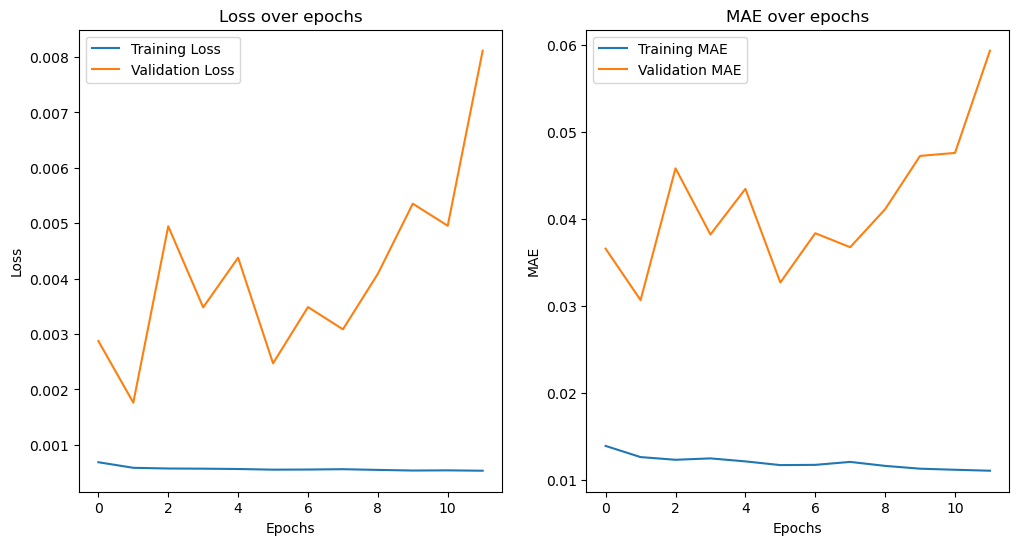

In [55]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# ساخت مدل GRU
model_gru = Sequential()
model_gru.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_gru.add(GRU(32))
model_gru.add(Dense(1))

# کامپایل مدل
model_gru.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])

# EarlyStopping برای جلوگیری از overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# آموزش مدل
history_gru = model_gru.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), 
                            callbacks=[early_stopping], verbose=1)

# ارزیابی مدل بر روی داده‌های تست
test_loss, test_mae = model_gru.evaluate(X_test, y_test)

# نمایش نتایج
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

# ترسیم نمودارها برای loss و mae
import matplotlib.pyplot as plt

# نمودار loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# نمودار MAE
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['mae'], label='Training MAE')
plt.plot(history_gru.history['val_mae'], label='Validation MAE')
plt.title('MAE over epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


Epoch 1/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - loss: 0.0022 - mae: 0.0224 - val_loss: 0.0031 - val_mae: 0.0371
Epoch 2/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 52s 72ms/step - loss: 5.6984e-04 - mae: 0.0126 - val_loss: 0.0028 - val_mae: 0.0358
Epoch 3/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - loss: 5.8699e-04 - mae: 0.0129 - val_loss: 0.0019 - val_mae: 0.0333
Epoch 4/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 5.8667e-04 - mae: 0.0128 - val_loss: 0.0018 - val_mae: 0.0352
Epoch 5/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 5.6478e-04 - mae: 0.0125 - val_loss: 0.0030 - val_mae: 0.0374
Epoch 6/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - loss: 5.7099e-04 - mae: 0.0121 - val_loss: 0.0045 - val_mae: 0.0434
Epoch 7/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 47s 66ms/step - loss: 5.5094e-04 - mae: 0.0119 - val_loss: 0.0029 - val_mae: 0.0364
Epoch 8/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 51s 71ms/step - loss: 5.4597e-04 - mae: 0.0116 - val_loss: 0.0048 - val_mae: 0.0447
Epoch 9/30
7

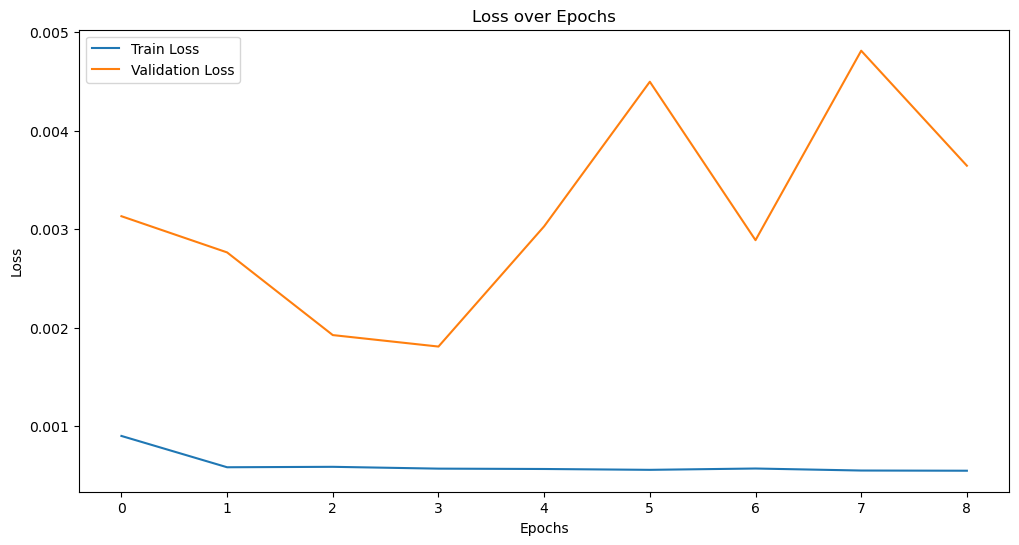

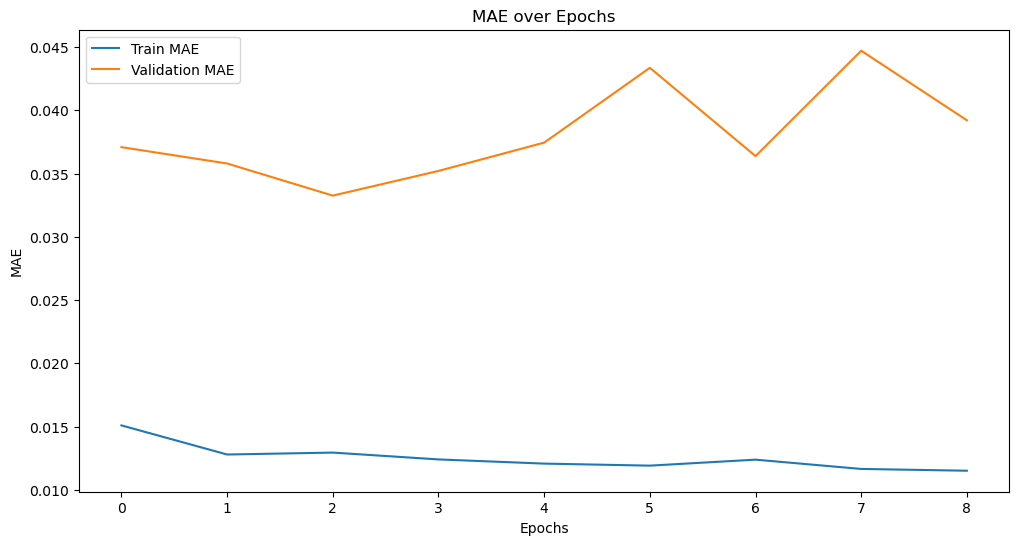

Test Loss: 0.0018090027151629329
Test MAE: 0.03520385921001434


In [56]:
from keras.models import Sequential
from keras.layers import Bidirectional, GRU, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# تعریف مدل
model_bidirectional_gru = Sequential()
model_bidirectional_gru.add(Bidirectional(GRU(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_bidirectional_gru.add(GRU(64))
model_bidirectional_gru.add(Dense(1))

# کامپایل مدل
model_bidirectional_gru.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])

# اضافه کردن EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# آموزش مدل
history_bidirectional_gru = model_bidirectional_gru.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

# نتایج آموزش
train_loss = history_bidirectional_gru.history['loss']
val_loss = history_bidirectional_gru.history['val_loss']
train_mae = history_bidirectional_gru.history['mae']
val_mae = history_bidirectional_gru.history['val_mae']

# رسم نمودار
import matplotlib.pyplot as plt

# رسم نمودار Loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# رسم نمودار MAE
plt.figure(figsize=(12, 6))
plt.plot(train_mae, label="Train MAE")
plt.plot(val_mae, label="Validation MAE")
plt.title("MAE over Epochs")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

# ارزیابی مدل
test_loss, test_mae = model_bidirectional_gru.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")


## BIGRU

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# ساخت مدل Bidirectional GRU با لایه‌های اضافی و رگولاریزیشن
model_bidirectional_gru = Sequential()

# اضافه کردن لایه Bidirectional GRU با L2 regularization
model_bidirectional_gru.add(Bidirectional(GRU(64, activation='relu', return_sequences=True, 
                                              kernel_regularizer=l2(0.01)), input_shape=(X_train.shape[1], X_train.shape[2])))

# نرمال‌سازی داده‌ها با BatchNormalization
model_bidirectional_gru.add(BatchNormalization())

# لایه Dropout برای جلوگیری از overfitting
model_bidirectional_gru.add(Dropout(0.3))

# اضافه کردن لایه Bidirectional GRU دوم
model_bidirectional_gru.add(Bidirectional(GRU(64, activation='relu', return_sequences=True, 
                                              kernel_regularizer=l2(0.01))))

# نرمال‌سازی داده‌ها با BatchNormalization
model_bidirectional_gru.add(BatchNormalization())

# لایه Dropout بیشتر
model_bidirectional_gru.add(Dropout(0.3))

# لایه Dense برای خروجی
model_bidirectional_gru.add(Dense(1))

# کامپایل مدل با استفاده از Adam optimizer
model_bidirectional_gru.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# استفاده از EarlyStopping برای جلوگیری از overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# آموزش مدل
history_bidirectional_gru = model_bidirectional_gru.fit(X_train, y_train, epochs=30, batch_size=32,
                                                         validation_data=(X_test, y_test),
                                                         verbose=1, callbacks=[early_stopping])

# ارزیابی مدل بر روی داده‌های تست
test_loss, test_mae = model_bidirectional_gru.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")


Epoch 1/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - loss: 1.6324 - mae: 0.4468 - val_loss: 0.2752 - val_mae: 0.3592
Epoch 2/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - loss: 0.0825 - mae: 0.1067 - val_loss: 0.2192 - val_mae: 0.3780
Epoch 3/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 53s 73ms/step - loss: 0.0318 - mae: 0.1051 - val_loss: 0.2088 - val_mae: 0.3806
Epoch 4/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - loss: 0.0235 - mae: 0.1054 - val_loss: 0.2016 - val_mae: 0.3742
Epoch 5/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.0220 - mae: 0.1060 - val_loss: 0.2036 - val_mae: 0.3775
Epoch 6/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.0204 - mae: 0.1019 - val_loss: 0.2007 - val_mae: 0.3737
Epoch 7/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 50s 70ms/step - loss: 0.0212 - mae: 0.1048 - val_loss: 0.2081 - val_mae: 0.3834
Epoch 8/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 46s 64ms/step - loss: 0.0207 - mae: 0.1025 - val_loss: 0.2035 - val_mae: 0.3774
Epoch 9/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 

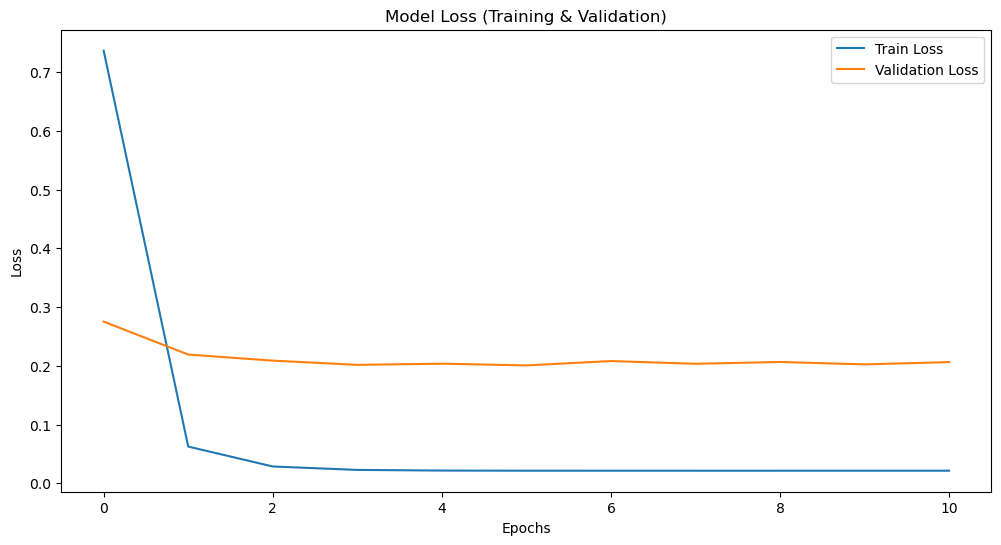

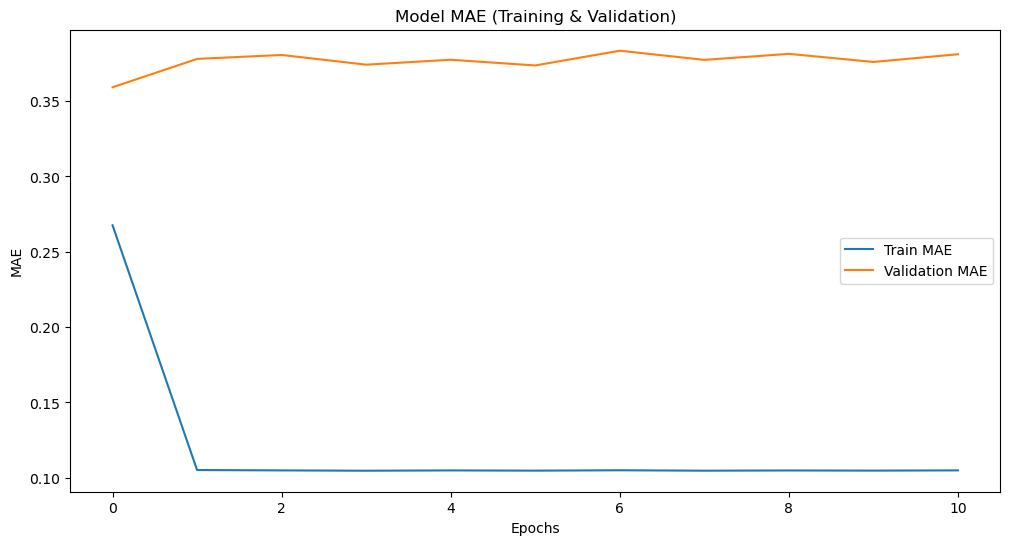

In [58]:
import matplotlib.pyplot as plt

# رسم نمودار خطای آموزش و اعتبارسنجی
plt.figure(figsize=(12, 6))
plt.plot(history_bidirectional_gru.history['loss'], label='Train Loss')
plt.plot(history_bidirectional_gru.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Training & Validation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# رسم نمودار MAE (میانگین خطای مطلق)
plt.figure(figsize=(12, 6))
plt.plot(history_bidirectional_gru.history['mae'], label='Train MAE')
plt.plot(history_bidirectional_gru.history['val_mae'], label='Validation MAE')

plt.title('Model MAE (Training & Validation)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


## STACKED BILSTM

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

def build_stacked_bilstm(
    timesteps, n_features,
    units1=128, units2=64, units3=32,
    dropout_rnn=0.3, dropout_dense=0.2,
    l2_rnn=1e-4, l2_dense=1e-4,
    lr=1e-3
):
    model = Sequential([
        Input(shape=(timesteps, n_features)),

        # BiLSTM #1
        Bidirectional(
            LSTM(units1, return_sequences=True,
                 kernel_regularizer=l2(l2_rnn),
                 recurrent_regularizer=l2(l2_rnn))
        ),
        BatchNormalization(),
        Dropout(dropout_rnn),

        # BiLSTM #2
        Bidirectional(
            LSTM(units2, return_sequences=True,
                 kernel_regularizer=l2(l2_rnn),
                 recurrent_regularizer=l2(l2_rnn))
        ),
        BatchNormalization(),
        Dropout(dropout_rnn),

        # BiLSTM #3 (خروجی نهایی توالی)
        Bidirectional(
            LSTM(units3, return_sequences=False,
                 kernel_regularizer=l2(l2_rnn),
                 recurrent_regularizer=l2(l2_rnn))
        ),
        BatchNormalization(),

        # Head
        Dense(64, activation='relu', kernel_regularizer=l2(l2_dense)),
        Dropout(dropout_dense),
        Dense(32, activation='relu', kernel_regularizer=l2(l2_dense)),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model

# ساخت مدل
timesteps, n_features = X_train.shape[1], X_train.shape[2]
model_bilstm = build_stacked_bilstm(timesteps, n_features)

# کال‌بک‌ها:‌ توقف زودهنگام + کاهش نرخ یادگیری + ذخیره بهترین وزن‌ها
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
ckpt = ModelCheckpoint('best_stacked_bilstm.h5', monitor='val_loss', save_best_only=True, verbose=1)

history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[es, rlr, ckpt],
    verbose=1
)

# ارزیابی نهایی
test_loss, test_mae = model_bilstm.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.6f} | Test MAE: {test_mae:.6f}")


Epoch 1/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1903 - mae: 0.1544
Epoch 1: val_loss improved from inf to 0.15042, saving model to best_stacked_bilstm.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 89s 107ms/step - loss: 0.1902 - mae: 0.1543 - val_loss: 0.1504 - val_mae: 0.1626 - learning_rate: 0.0010
Epoch 2/60
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0892 - mae: 0.0336
Epoch 2: val_loss improved from 0.15042 to 0.07715, saving model to best_stacked_bilstm.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - loss: 0.0892 - mae: 0.0336 - val_loss: 0.0772 - val_mae: 0.0780 - learning_rate: 0.0010
Epoch 3/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0583 - mae: 0.0256
Epoch 3: val_loss improved from 0.07715 to 0.06657, saving model to best_stacked_bilstm.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - loss: 0.0583 - mae: 0.0256 - val_loss: 0.0666 - val_mae: 0.1078 - learning_rate: 0.0010
Epoch 4/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0370 - mae: 0.0215
Epoch 4: val_loss improved from 0.06657 to 0.04838, saving model to best_stacked_bilstm.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 76s 107ms/step - loss: 0.0370 - mae: 0.0215 - val_loss: 0.0484 - val_mae: 0.1046 - learning_rate: 0.0010
Epoch 5/60
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0229 - mae: 0.0197
Epoch 5: val_loss improved from 0.04838 to 0.03425, saving model to best_stacked_bilstm.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - loss: 0.0229 - mae: 0.0197 - val_loss: 0.0342 - val_mae: 0.0999 - learning_rate: 0.0010
Epoch 6/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0137 - mae: 0.0179
Epoch 6: val_loss did not improve from 0.03425
717/717 ━━━━━━━━━━━━━━━━━━━━ 54s 76ms/step - loss: 0.0137 - mae: 0.0179 - val_loss: 0.0531 - val_mae: 0.1497 - learning_rate: 0.0010
Epoch 7/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0080 - mae: 0.0163
Epoch 7: val_loss did not improve from 0.03425
717/717 ━━━━━━━━━━━━━━━━━━━━ 68s 95ms/step - loss: 0.0080 - mae: 0.0163 - val_loss: 0.0397 - val_mae: 0.1359 - learning_rate: 0.0010
Epoch 8/60
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0048 - mae: 0.0166
Epoch 8: val_loss improved from 0.03425 to 0.03193, saving model to best_stacked_bilstm.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - loss: 0.0048 - mae: 0.0166 - val_loss: 0.0319 - val_mae: 0.1177 - learning_rate: 0.0010
Epoch 9/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0031 - mae: 0.0169
Epoch 9: val_loss did not improve from 0.03193
717/717 ━━━━━━━━━━━━━━━━━━━━ 46s 65ms/step - loss: 0.0031 - mae: 0.0169 - val_loss: 0.0359 - val_mae: 0.1274 - learning_rate: 0.0010
Epoch 10/60
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0022 - mae: 0.0171
Epoch 10: val_loss improved from 0.03193 to 0.03140, saving model to best_stacked_bilstm.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 73s 101ms/step - loss: 0.0022 - mae: 0.0171 - val_loss: 0.0314 - val_mae: 0.1318 - learning_rate: 0.0010
Epoch 11/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0016 - mae: 0.0158
Epoch 11: val_loss improved from 0.03140 to 0.02454, saving model to best_stacked_bilstm.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - loss: 0.0016 - mae: 0.0158 - val_loss: 0.0245 - val_mae: 0.1154 - learning_rate: 0.0010
Epoch 12/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0017 - mae: 0.0173
Epoch 12: val_loss did not improve from 0.02454
717/717 ━━━━━━━━━━━━━━━━━━━━ 55s 76ms/step - loss: 0.0017 - mae: 0.0173 - val_loss: 0.0322 - val_mae: 0.1207 - learning_rate: 0.0010
Epoch 13/60
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0017 - mae: 0.0175
Epoch 13: val_loss did not improve from 0.02454
717/717 ━━━━━━━━━━━━━━━━━━━━ 60s 84ms/step - loss: 0.0017 - mae: 0.0175 - val_loss: 0.0347 - val_mae: 0.1280 - learning_rate: 0.0010
Epoch 14/60
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0018 - mae: 0.0181
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: val_loss did not improve from 0.02454
717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - loss: 0.0018 - mae: 0.0181 - val_loss: 0.0325 - val_mae: 0.1262 - learning_rate: 0.00

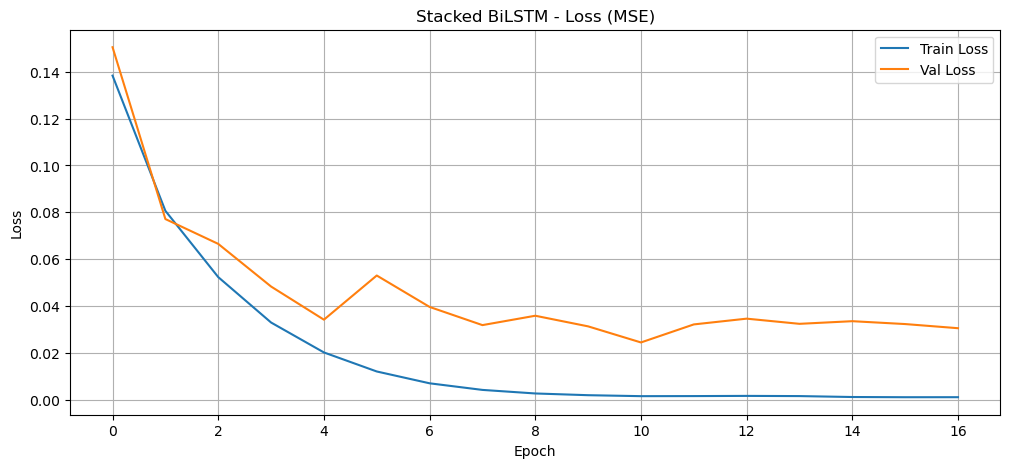

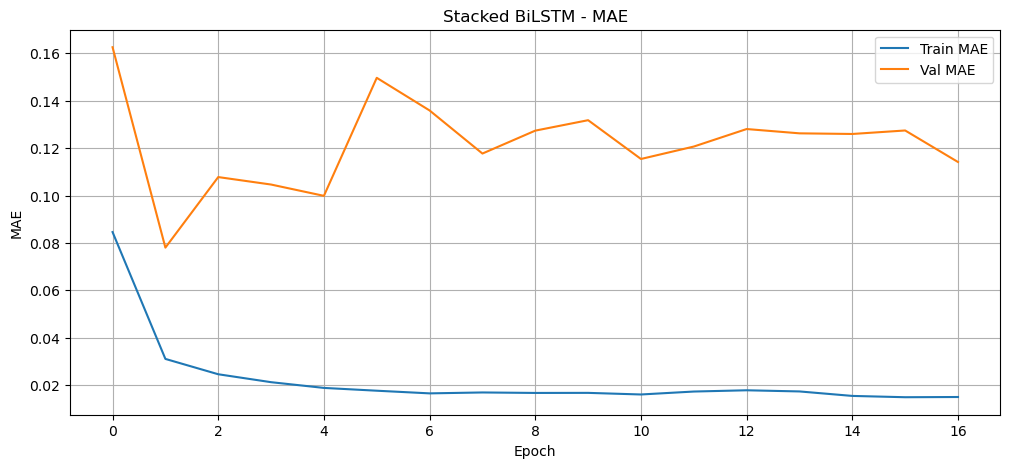

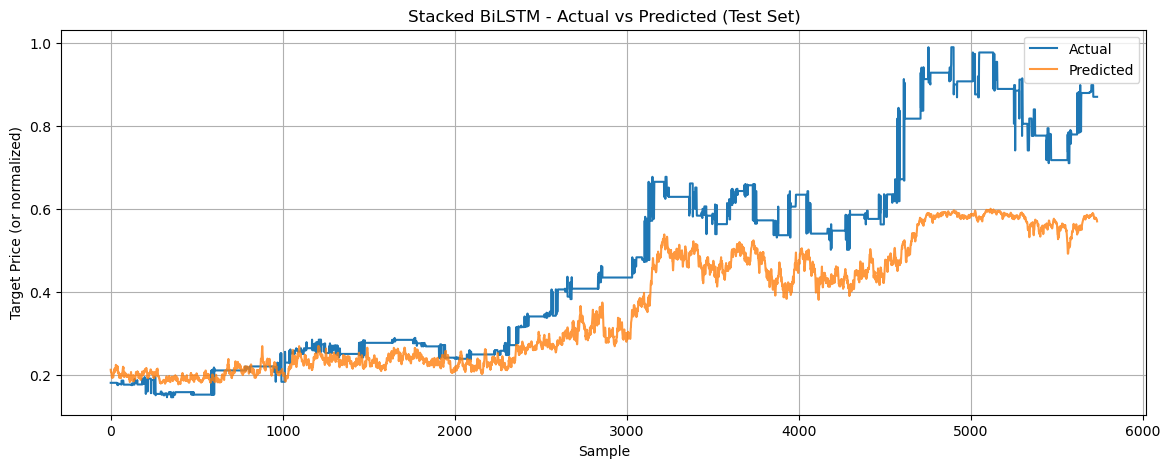

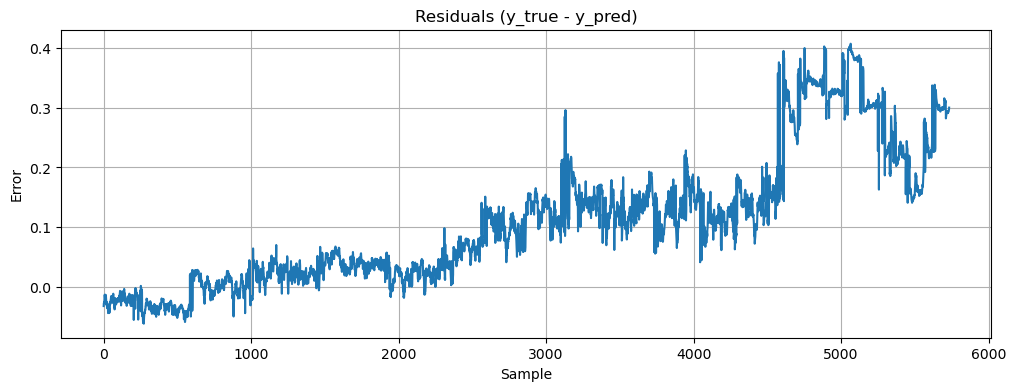

RMSE: 0.154671 | MAPE: 20.42%


In [60]:
import matplotlib.pyplot as plt
import numpy as np

# 1) نمودار Loss
plt.figure(figsize=(12,5))
plt.plot(history_bilstm.history['loss'], label='Train Loss')
plt.plot(history_bilstm.history['val_loss'], label='Val Loss')
plt.title('Stacked BiLSTM - Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 2) نمودار MAE
plt.figure(figsize=(12,5))
plt.plot(history_bilstm.history['mae'], label='Train MAE')
plt.plot(history_bilstm.history['val_mae'], label='Val MAE')
plt.title('Stacked BiLSTM - MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# 3) پیش‌بینی مقابل واقعی (روی تست)
y_pred = model_bilstm.predict(X_test, verbose=0).reshape(-1)
y_true = y_test.reshape(-1)

plt.figure(figsize=(14,5))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.8)
plt.title('Stacked BiLSTM - Actual vs Predicted (Test Set)')
plt.xlabel('Sample')
plt.ylabel('Target Price (or normalized)')
plt.legend()
plt.grid(True)
plt.show()

# 4) پخش خطا (Residuals)
res = y_true - y_pred
plt.figure(figsize=(12,4))
plt.plot(res)
plt.title('Residuals (y_true - y_pred)')
plt.xlabel('Sample')
plt.ylabel('Error')
plt.grid(True)
plt.show()

# 5) معیارهای کمکی سریع
mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-9, None))) * 100
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
print(f"RMSE: {rmse:.6f} | MAPE: {mape:.2f}%")


## STACKED BILSTM WITH ATTENTION

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ===== لایه Attention سفارشی =====
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(inputs, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = inputs * a
        return tf.keras.backend.sum(output, axis=1)

# ===== ساخت مدل =====
def build_stacked_bilstm_attention(timesteps, n_features,
                                   units1=128, units2=64,
                                   dropout_rnn=0.3, dropout_dense=0.2,
                                   l2_rnn=1e-4, l2_dense=1e-4,
                                   lr=1e-3):
    inp = Input(shape=(timesteps, n_features))

    # لایه اول BiLSTM
    x = Bidirectional(LSTM(units1, return_sequences=True,
                           kernel_regularizer=l2(l2_rnn),
                           recurrent_regularizer=l2(l2_rnn)))(inp)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rnn)(x)

    # لایه دوم BiLSTM
    x = Bidirectional(LSTM(units2, return_sequences=True,
                           kernel_regularizer=l2(l2_rnn),
                           recurrent_regularizer=l2(l2_rnn)))(x)
    x = BatchNormalization()(x)  # ← اینجا باگ قبلی رو اصلاح کردیم
    x = Dropout(dropout_rnn)(x)

    # لایه Attention
    x = Attention()(x)

    # Dense layers
    x = Dense(64, activation='relu', kernel_regularizer=l2(l2_dense))(x)
    x = Dropout(dropout_dense)(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(l2_dense))(x)
    out = Dense(1, activation='linear')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model

# ===== ساخت و آموزش =====
timesteps, n_features = X_train.shape[1], X_train.shape[2]
model_attn = build_stacked_bilstm_attention(timesteps, n_features)

es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
ckpt = ModelCheckpoint('best_stacked_bilstm_attention.h5', monitor='val_loss', save_best_only=True, verbose=1)

history_attn = model_attn.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[es, rlr, ckpt],
    verbose=1
)

# ===== ارزیابی =====
test_loss, test_mae = model_attn.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.6f} | Test MAE: {test_mae:.6f}")


Epoch 1/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1092 - mae: 0.0804
Epoch 1: val_loss improved from inf to 0.07490, saving model to best_stacked_bilstm_attention.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 77s 92ms/step - loss: 0.1091 - mae: 0.0804 - val_loss: 0.0749 - val_mae: 0.1370 - learning_rate: 0.0010
Epoch 2/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0371 - mae: 0.0212
Epoch 2: val_loss improved from 0.07490 to 0.05805, saving model to best_stacked_bilstm_attention.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - loss: 0.0370 - mae: 0.0212 - val_loss: 0.0580 - val_mae: 0.1373 - learning_rate: 0.0010
Epoch 3/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0184 - mae: 0.0184
Epoch 3: val_loss improved from 0.05805 to 0.03726, saving model to best_stacked_bilstm_attention.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - loss: 0.0184 - mae: 0.0184 - val_loss: 0.0373 - val_mae: 0.1159 - learning_rate: 0.0010
Epoch 4/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0100 - mae: 0.0171
Epoch 4: val_loss did not improve from 0.03726
717/717 ━━━━━━━━━━━━━━━━━━━━ 51s 72ms/step - loss: 0.0100 - mae: 0.0171 - val_loss: 0.0374 - val_mae: 0.1277 - learning_rate: 0.0010
Epoch 5/60
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0056 - mae: 0.0169
Epoch 5: val_loss improved from 0.03726 to 0.02961, saving model to best_stacked_bilstm_attention.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 70s 98ms/step - loss: 0.0056 - mae: 0.0169 - val_loss: 0.0296 - val_mae: 0.1115 - learning_rate: 0.0010
Epoch 6/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0033 - mae: 0.0164
Epoch 6: val_loss improved from 0.02961 to 0.01941, saving model to best_stacked_bilstm_attention.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - loss: 0.0033 - mae: 0.0164 - val_loss: 0.0194 - val_mae: 0.0941 - learning_rate: 0.0010
Epoch 7/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0022 - mae: 0.0170
Epoch 7: val_loss did not improve from 0.01941
717/717 ━━━━━━━━━━━━━━━━━━━━ 82s 114ms/step - loss: 0.0022 - mae: 0.0170 - val_loss: 0.0276 - val_mae: 0.1150 - learning_rate: 0.0010
Epoch 8/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0015 - mae: 0.0164
Epoch 8: val_loss did not improve from 0.01941
717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - loss: 0.0015 - mae: 0.0164 - val_loss: 0.0300 - val_mae: 0.1187 - learning_rate: 0.0010
Epoch 9/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0014 - mae: 0.0171
Epoch 9: val_loss improved from 0.01941 to 0.01256, saving model to best_stacked_bilstm_attention.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - loss: 0.0014 - mae: 0.0171 - val_loss: 0.0126 - val_mae: 0.0760 - learning_rate: 0.0010
Epoch 10/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0012 - mae: 0.0165
Epoch 10: val_loss did not improve from 0.01256
717/717 ━━━━━━━━━━━━━━━━━━━━ 71s 99ms/step - loss: 0.0012 - mae: 0.0165 - val_loss: 0.0239 - val_mae: 0.1102 - learning_rate: 0.0010
Epoch 11/60
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0012 - mae: 0.0160
Epoch 11: val_loss did not improve from 0.01256
717/717 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - loss: 0.0012 - mae: 0.0160 - val_loss: 0.0282 - val_mae: 0.1340 - learning_rate: 0.0010
Epoch 12/60
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0011 - mae: 0.0162
Epoch 12: val_loss improved from 0.01256 to 0.00775, saving model to best_stacked_bilstm_attention.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - loss: 0.0011 - mae: 0.0162 - val_loss: 0.0078 - val_mae: 0.0545 - learning_rate: 0.0010
Epoch 13/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0011 - mae: 0.0161
Epoch 13: val_loss did not improve from 0.00775
717/717 ━━━━━━━━━━━━━━━━━━━━ 66s 92ms/step - loss: 0.0011 - mae: 0.0161 - val_loss: 0.0327 - val_mae: 0.1349 - learning_rate: 0.0010
Epoch 14/60
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0011 - mae: 0.0158
Epoch 14: val_loss did not improve from 0.00775
717/717 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - loss: 0.0011 - mae: 0.0158 - val_loss: 0.0392 - val_mae: 0.1419 - learning_rate: 0.0010
Epoch 15/60
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0011 - mae: 0.0158
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: val_loss did not improve from 0.00775
717/717 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - loss: 0.0011 - mae: 0.0158 - val_loss: 0.0204 - val_mae: 0.1029 - learning_rate: 0.00

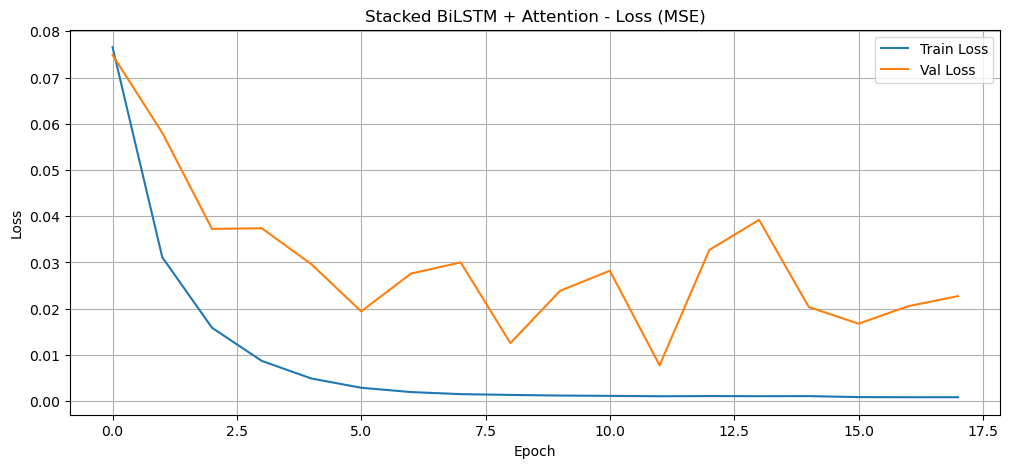

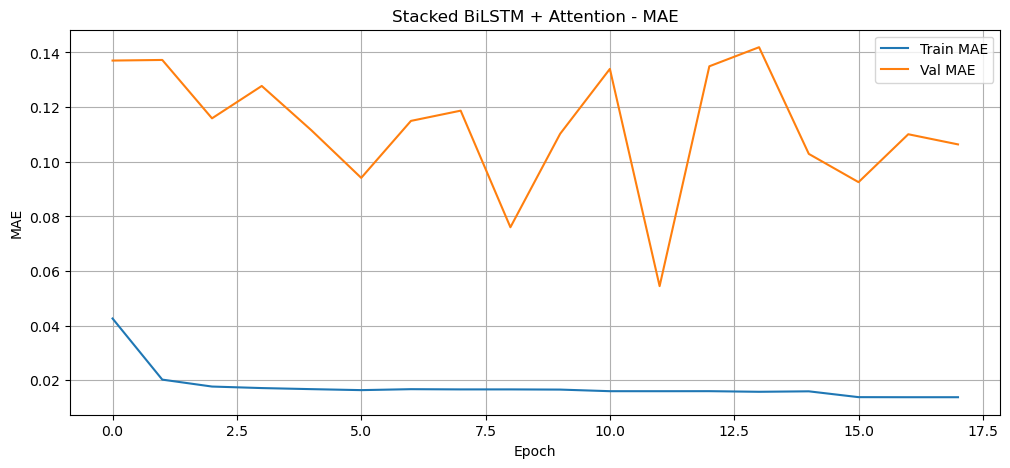

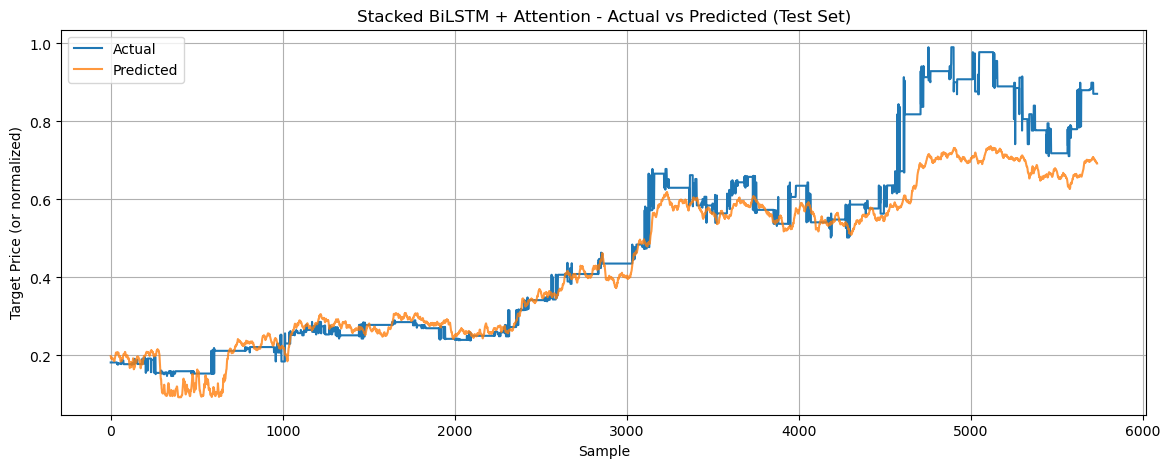

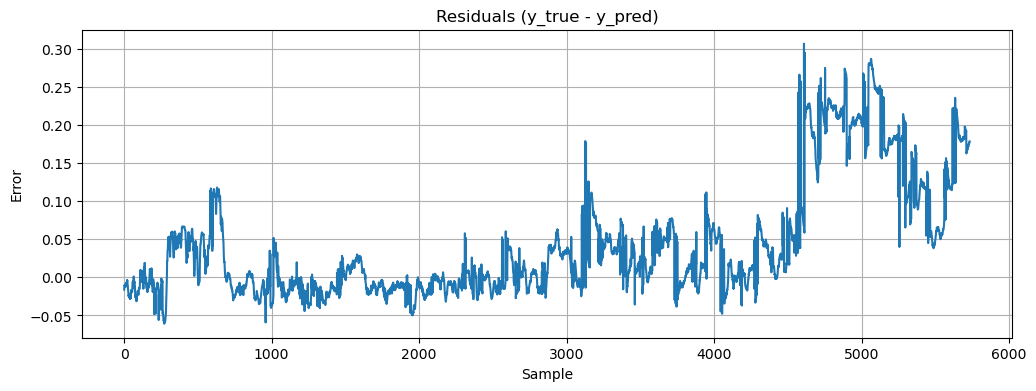

RMSE: 0.086451 | MAPE: 10.37%


In [62]:
import matplotlib.pyplot as plt
import numpy as np

# 1) نمودار Loss
plt.figure(figsize=(12,5))
plt.plot(history_attn.history['loss'], label='Train Loss')
plt.plot(history_attn.history['val_loss'], label='Val Loss')
plt.title('Stacked BiLSTM + Attention - Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 2) نمودار MAE
plt.figure(figsize=(12,5))
plt.plot(history_attn.history['mae'], label='Train MAE')
plt.plot(history_attn.history['val_mae'], label='Val MAE')
plt.title('Stacked BiLSTM + Attention - MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# 3) پیش‌بینی مقابل واقعی (روی تست)
y_pred = model_attn.predict(X_test, verbose=0).reshape(-1)
y_true = y_test.reshape(-1)

plt.figure(figsize=(14,5))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.8)
plt.title('Stacked BiLSTM + Attention - Actual vs Predicted (Test Set)')
plt.xlabel('Sample')
plt.ylabel('Target Price (or normalized)')
plt.legend()
plt.grid(True)
plt.show()

# 4) پخش خطا (Residuals)
res = y_true - y_pred
plt.figure(figsize=(12,4))
plt.plot(res)
plt.title('Residuals (y_true - y_pred)')
plt.xlabel('Sample')
plt.ylabel('Error')
plt.grid(True)
plt.show()

# 5) معیارهای کمکی سریع
mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-9, None))) * 100
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
print(f"RMSE: {rmse:.6f} | MAPE: {mape:.2f}%")


## STACKED BIGRU with attention

Epoch 1/60
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.1081 - mae: 0.0789
Epoch 1: val_loss improved from inf to 0.07934, saving model to best_stacked_bigru_attention.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 99s 113ms/step - loss: 0.1080 - mae: 0.0788 - val_loss: 0.0793 - val_mae: 0.1357 - learning_rate: 0.0010
Epoch 2/60
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0355 - mae: 0.0257
Epoch 2: val_loss improved from 0.07934 to 0.04036, saving model to best_stacked_bigru_attention.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - loss: 0.0355 - mae: 0.0257 - val_loss: 0.0404 - val_mae: 0.0958 - learning_rate: 0.0010
Epoch 3/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0173 - mae: 0.0212
Epoch 3: val_loss improved from 0.04036 to 0.03621, saving model to best_stacked_bigru_attention.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 63s 87ms/step - loss: 0.0173 - mae: 0.0212 - val_loss: 0.0362 - val_mae: 0.1073 - learning_rate: 0.0010
Epoch 4/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0089 - mae: 0.0197
Epoch 4: val_loss did not improve from 0.03621
717/717 ━━━━━━━━━━━━━━━━━━━━ 63s 87ms/step - loss: 0.0089 - mae: 0.0197 - val_loss: 0.0365 - val_mae: 0.1210 - learning_rate: 0.0010
Epoch 5/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0048 - mae: 0.0193
Epoch 5: val_loss improved from 0.03621 to 0.03122, saving model to best_stacked_bigru_attention.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 43s 60ms/step - loss: 0.0048 - mae: 0.0193 - val_loss: 0.0312 - val_mae: 0.1151 - learning_rate: 0.0010
Epoch 6/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0030 - mae: 0.0196
Epoch 6: val_loss did not improve from 0.03122
717/717 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - loss: 0.0030 - mae: 0.0196 - val_loss: 0.0373 - val_mae: 0.1415 - learning_rate: 0.0010
Epoch 7/60
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0021 - mae: 0.0193
Epoch 7: val_loss improved from 0.03122 to 0.02769, saving model to best_stacked_bigru_attention.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - loss: 0.0021 - mae: 0.0193 - val_loss: 0.0277 - val_mae: 0.1149 - learning_rate: 0.0010
Epoch 8/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0016 - mae: 0.0183
Epoch 8: val_loss did not improve from 0.02769
717/717 ━━━━━━━━━━━━━━━━━━━━ 63s 88ms/step - loss: 0.0016 - mae: 0.0183 - val_loss: 0.0370 - val_mae: 0.1412 - learning_rate: 0.0010
Epoch 9/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0014 - mae: 0.0172
Epoch 9: val_loss did not improve from 0.02769
717/717 ━━━━━━━━━━━━━━━━━━━━ 63s 87ms/step - loss: 0.0014 - mae: 0.0172 - val_loss: 0.0453 - val_mae: 0.1517 - learning_rate: 0.0010
Epoch 10/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0014 - mae: 0.0183
Epoch 10: val_loss improved from 0.02769 to 0.02302, saving model to best_stacked_bigru_attention.h5


717/717 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - loss: 0.0014 - mae: 0.0183 - val_loss: 0.0230 - val_mae: 0.1045 - learning_rate: 0.0010
Epoch 11/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0013 - mae: 0.0178
Epoch 11: val_loss did not improve from 0.02302
717/717 ━━━━━━━━━━━━━━━━━━━━ 106s 149ms/step - loss: 0.0013 - mae: 0.0178 - val_loss: 0.0309 - val_mae: 0.1539 - learning_rate: 0.0010
Epoch 12/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0013 - mae: 0.0172
Epoch 12: val_loss did not improve from 0.02302
717/717 ━━━━━━━━━━━━━━━━━━━━ 49s 69ms/step - loss: 0.0013 - mae: 0.0172 - val_loss: 0.0319 - val_mae: 0.1286 - learning_rate: 0.0010
Epoch 13/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0013 - mae: 0.0178
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: val_loss did not improve from 0.02302
717/717 ━━━━━━━━━━━━━━━━━━━━ 98s 137ms/step - loss: 0.0013 - mae: 0.0178 - val_loss: 0.0379 - val_mae: 0.1344 - learning_rate:

717/717 ━━━━━━━━━━━━━━━━━━━━ 52s 73ms/step - loss: 0.0011 - mae: 0.0155 - val_loss: 0.0167 - val_mae: 0.0861 - learning_rate: 5.0000e-04
Epoch 15/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0011 - mae: 0.0157
Epoch 15: val_loss did not improve from 0.01674
717/717 ━━━━━━━━━━━━━━━━━━━━ 97s 135ms/step - loss: 0.0011 - mae: 0.0157 - val_loss: 0.0300 - val_mae: 0.1244 - learning_rate: 5.0000e-04
Epoch 16/60
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0010 - mae: 0.0153
Epoch 16: val_loss did not improve from 0.01674
717/717 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - loss: 0.0010 - mae: 0.0153 - val_loss: 0.0261 - val_mae: 0.1084 - learning_rate: 5.0000e-04
Epoch 17/60
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0010 - mae: 0.0155
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: val_loss did not improve from 0.01674
717/717 ━━━━━━━━━━━━━━━━━━━━ 62s 86ms/step - loss: 0.0010 - mae: 0.0155 - val_loss: 0.0195 - val_mae: 0.0895 - learn

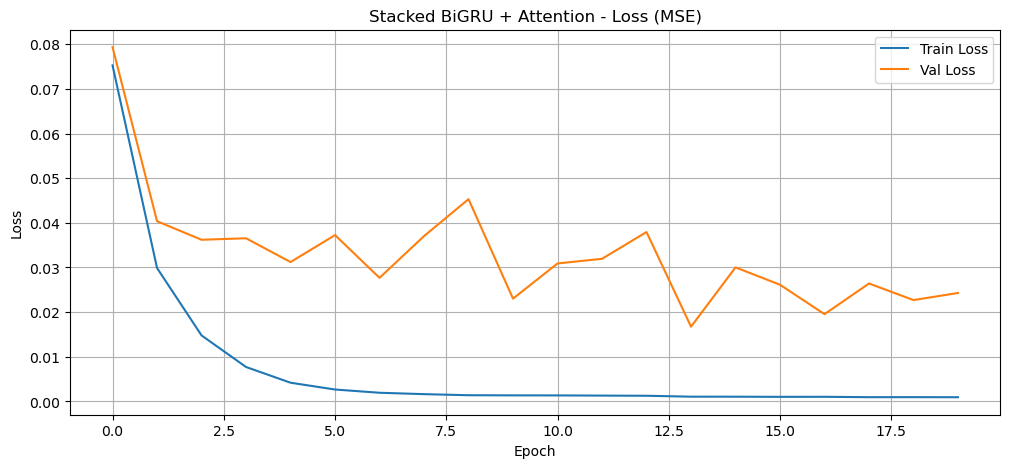

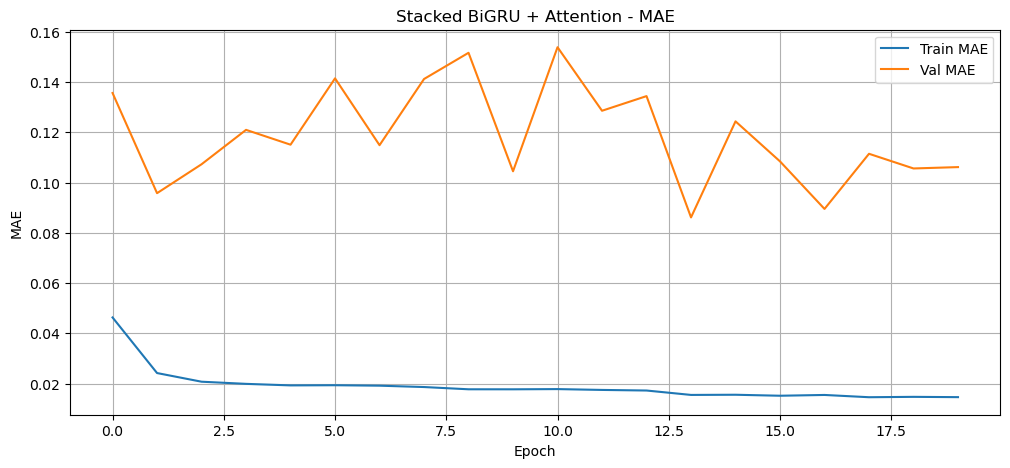

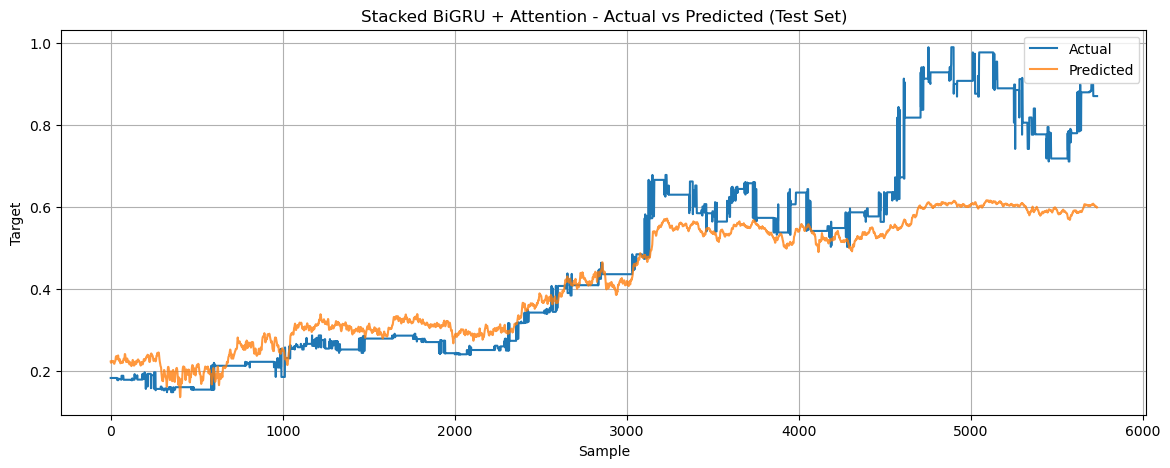

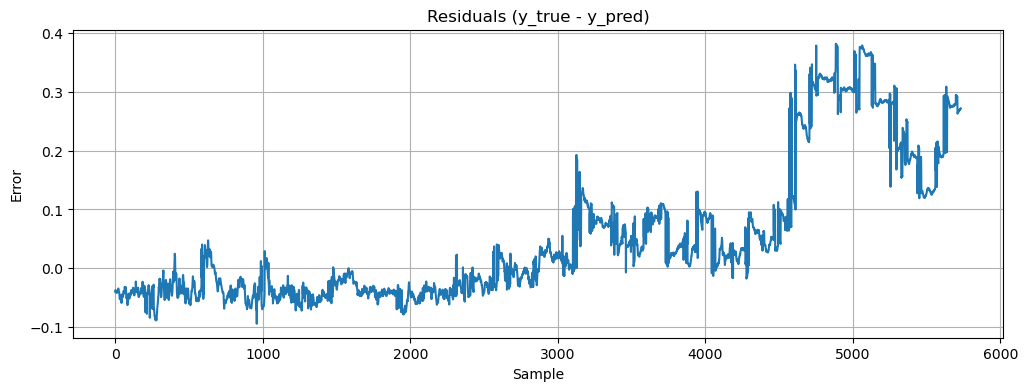

RMSE: 0.128326 | MAPE: 16.68%


In [63]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, GRU, Dense, Dropout, BatchNormalization, Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

# --- Attention Layer ---
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)
    def call(self, inputs):
        e = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        context = tf.reduce_sum(inputs * a, axis=1)
        return context

# --- Model Builder ---
def build_stacked_bigru_attention(timesteps, n_features,
                                  units1=128, units2=64, units3=32,
                                  dropout_rnn=0.3, dropout_dense=0.2,
                                  l2_rnn=1e-4, l2_dense=1e-4, lr=1e-3):
    inp = Input(shape=(timesteps, n_features))
    x = Bidirectional(GRU(units1, return_sequences=True,
                          kernel_regularizer=l2(l2_rnn),
                          recurrent_regularizer=l2(l2_rnn)))(inp)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rnn)(x)

    x = Bidirectional(GRU(units2, return_sequences=True,
                          kernel_regularizer=l2(l2_rnn),
                          recurrent_regularizer=l2(l2_rnn)))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rnn)(x)

    x = Bidirectional(GRU(units3, return_sequences=True,
                          kernel_regularizer=l2(l2_rnn),
                          recurrent_regularizer=l2(l2_rnn)))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rnn)(x)

    x = Attention()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(l2_dense))(x)
    x = Dropout(dropout_dense)(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(l2_dense))(x)
    out = Dense(1, activation='linear')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model

# --- Train ---
timesteps, n_features = X_train.shape[1], X_train.shape[2]
model_bigru_attn = build_stacked_bigru_attention(timesteps, n_features)

es  = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
ckp = ModelCheckpoint('best_stacked_bigru_attention.h5', monitor='val_loss', save_best_only=True, verbose=1)

history_bigru_attn = model_bigru_attn.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[es, rlr, ckp],
    verbose=1
)

# --- Evaluate ---
test_loss, test_mae = model_bigru_attn.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.6f} | Test MAE: {test_mae:.6f}")

# --- Plots ---
# 1) Loss
plt.figure(figsize=(12,5))
plt.plot(history_bigru_attn.history['loss'], label='Train Loss')
plt.plot(history_bigru_attn.history['val_loss'], label='Val Loss')
plt.title('Stacked BiGRU + Attention - Loss (MSE)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True); plt.show()

# 2) MAE
plt.figure(figsize=(12,5))
plt.plot(history_bigru_attn.history['mae'], label='Train MAE')
plt.plot(history_bigru_attn.history['val_mae'], label='Val MAE')
plt.title('Stacked BiGRU + Attention - MAE')
plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.legend(); plt.grid(True); plt.show()

# 3) Actual vs Predicted
y_pred = model_bigru_attn.predict(X_test, verbose=0).reshape(-1)
y_true = y_test.reshape(-1)
plt.figure(figsize=(14,5))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.8)
plt.title('Stacked BiGRU + Attention - Actual vs Predicted (Test Set)')
plt.xlabel('Sample'); plt.ylabel('Target'); plt.legend(); plt.grid(True); plt.show()

# 4) Residuals
res = y_true - y_pred
plt.figure(figsize=(12,4))
plt.plot(res)
plt.title('Residuals (y_true - y_pred)')
plt.xlabel('Sample'); plt.ylabel('Error'); plt.grid(True); plt.show()

# 5) Extra metrics
mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-9, None))) * 100
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
print(f"RMSE: {rmse:.6f} | MAPE: {mape:.2f}%")


# TIME PREDICTION

In [ ]:
# =========================
# Time-to-Exit (in hours) - In-Wave Only
# LSTM + L2 + Dropout + EarlyStopping + ReduceLROnPlateau + ModelCheckpoint
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_sample_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# -------------------------
# 0) Column config (edit if needed)
# -------------------------
DF = df_wave.copy()  # your dataset
col_wave_end = 'Wave_End'               # boolean-like end-of-wave flag
col_inwave_aux = 'Wave_Binary'          # optional, if exists ("InWave"/"NoWave")
label_like_cols = ['Wave_Label', 'Wave_Label_Full', 'Wave_Binary', 'Wave_Binary_Code',
                   'Wave_MultiClass', 'Next_Label']  # to exclude from features if present

# -------------------------
# 1) Ensure time index & sampling interval in hours
# -------------------------
if not isinstance(DF.index, pd.DatetimeIndex):
    DF.index = pd.to_datetime(DF.index)

# Estimate step duration (hours) from median delta between timestamps
if len(DF.index) > 1:
    step_hours = np.median(np.diff(DF.index.values).astype('timedelta64[m]').astype(float)) / 60.0
else:
    step_hours = 0.25  # fallback (e.g., 15 minutes)

# -------------------------
# 2) Build time_to_exit in "steps", then convert to hours
# -------------------------
# Normalize Wave_End to boolean
DF[col_wave_end] = DF[col_wave_end].fillna(False).astype(bool)

time_to_exit_steps = np.full(len(DF), np.nan, dtype=float)

# Forward scan for first True after each index
wave_end_array = DF[col_wave_end].values
for i in range(len(DF)):
    if wave_end_array[i]:
        time_to_exit_steps[i] = 0.0
    else:
        # find first True at j >= i
        # We'll search forward only if there exists any True ahead
        if wave_end_array[i+1:].any():
            j_rel = np.argmax(wave_end_array[i+1:])  # first True offset after i
            # if there is no True, argmax returns 0 but wave_end_array.any() ensures correctness
            time_to_exit_steps[i] = (j_rel + 1)  # steps until the next True
        else:
            time_to_exit_steps[i] = np.nan

DF['time_to_exit_steps'] = time_to_exit_steps
DF['time_to_exit_hours'] = DF['time_to_exit_steps'] * step_hours

# -------------------------
# 3) Keep only "in-wave" rows for training
#    If Wave_Binary exists, use it; otherwise: in-wave = not Wave_End
# -------------------------
if col_inwave_aux in DF.columns:
    inwave_mask = (DF[col_inwave_aux] == 'InWave')
else:
    inwave_mask = ~DF[col_wave_end]

# We also need a valid future exit (non-NaN label)
mask_valid = inwave_mask & DF['time_to_exit_hours'].notna()
DF = DF.loc[mask_valid].copy()

# -------------------------
# 4) Features selection (numeric only, exclude labels)
# -------------------------
exclude_cols = ['time_to_exit_steps', 'time_to_exit_hours', col_wave_end] + label_like_cols
feature_cols = [c for c in DF.columns
                if c not in exclude_cols and np.issubdtype(DF[c].dtype, np.number)]

# Fill NaNs in features by forward/backward fill to preserve time structure
DF[feature_cols] = DF[feature_cols].fillna(method='ffill').fillna(method='bfill')

# -------------------------
# 5) Target transform (log1p for stability), clip long tails (95% quantile)
# -------------------------
# Optional clipping to reduce extreme long horizons
q95 = DF['time_to_exit_hours'].quantile(0.95)
DF['tte_hours_clipped'] = DF['time_to_exit_hours'].clip(0, q95)

# log1p transform
DF['tte_target'] = np.log1p(DF['tte_hours_clipped'])

# -------------------------
# 6) Build sequences for LSTM
# -------------------------
SEQ_LEN = 30

scaler = StandardScaler()
feat_scaled = scaler.fit_transform(DF[feature_cols].values)

X_list, y_list, idx_list = [], [], []
for i in range(SEQ_LEN, len(DF)):
    X_list.append(feat_scaled[i-SEQ_LEN:i, :])
    y_list.append(DF['tte_target'].iloc[i])
    idx_list.append(DF.index[i])

X = np.array(X_list, dtype=np.float32)
y = np.array(y_list, dtype=np.float32)
idx_arr = np.array(idx_list)

# -------------------------
# 7) Train/Test split (time-based, no shuffling)
# -------------------------
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
idx_test = idx_arr[split_idx:]

# -------------------------
# 8) Optional: sample weights to reduce imbalance (by bucketing targets)
# -------------------------
# Create simple bins and weight inversely proportional to frequency
bins = np.linspace(y_train.min(), y_train.max(), num=20)
y_train_bins = np.digitize(y_train, bins)
class_weights = 1.0 / np.maximum(np.bincount(y_train_bins), 1)
sample_weights = class_weights[y_train_bins]

# -------------------------
# 9) LSTM model
# -------------------------
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False,
         kernel_regularizer=l2(1e-4), input_shape=(SEQ_LEN, X.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(1, activation='linear')  # Predict log1p(hours)
])

# ...
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])


es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
ckpt = ModelCheckpoint('best_time_to_exit_inwave.keras',  
                       monitor='val_loss',
                       save_best_only=True,
                       verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    epochs=60,
    batch_size=32,
    callbacks=[es, rlr, ckpt],
    verbose=1
)

# -------------------------
# 10) Evaluation (report in hours)
# -------------------------
# Load best weights (already restored by EarlyStopping if improved, but ensure)

best_model = load_model('best_time_to_exit_inwave.keras', compile=True)

y_pred_log = best_model.predict(X_test, verbose=0).reshape(-1)
y_pred_hours = np.expm1(y_pred_log)
y_true_hours = np.expm1(y_test)

mse_hours = np.mean((y_true_hours - y_pred_hours)**2)
mae_hours = np.mean(np.abs(y_true_hours - y_pred_hours))
print(f"Test MSE (hours^2): {mse_hours:.4f} | Test MAE (hours): {mae_hours:.4f}")

for i in range(min(15, len(y_true_hours))):
    print(f"Actual (h): {y_true_hours[i]:.2f} | Predicted (h): {y_pred_hours[i]:.2f}")


# -------------------------
# 11) Plots: MSE & MAE (training metrics reported on log-space)
# -------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train MSE (log-space)')
plt.plot(history.history['val_loss'], label='Val MSE (log-space)')
plt.title('Loss (MSE) over epochs')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE (log-space)')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE (log-space)')
plt.title('MAE over epochs')
plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()


# -------------------------
# 12) Plots: Actual vs Predicted (hours)
# -------------------------
plt.figure(figsize=(10,5))
plt.scatter(y_true_hours, y_pred_hours, alpha=0.5)
plt.xlabel('Actual time-to-exit (hours)')
plt.ylabel('Predicted time-to-exit (hours)')
plt.title('Actual vs Predicted (hours)')
plt.grid(True)
plt.show()

# A short time slice line plot
n_show = min(300, len(y_true_hours))
plt.figure(figsize=(14,4))
plt.plot(y_true_hours[:n_show], label='Actual (h)')
plt.plot(y_pred_hours[:n_show], label='Predicted (h)', alpha=0.8)
plt.title('Time slice: Actual vs Predicted time-to-exit (hours)')
plt.xlabel('Sample'); plt.ylabel('Hours to exit'); plt.legend(); plt.grid(True)
plt.show()


C:\Users\amirhossein\AppData\Local\Temp\ipykernel_16664\3206569618.py:87: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  DF[feature_cols] = DF[feature_cols].fillna(method='ffill').fillna(method='bfill')


Epoch 1/60


c:\Users\amirhossein\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0076 - mean_absolute_error: 1.7927
Epoch 1: val_loss improved from inf to 2.67504, saving model to best_time_to_exit_inwave.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - loss: 0.0076 - mean_absolute_error: 1.7920 - val_loss: 2.6750 - val_mean_absolute_error: 1.3660 - learning_rate: 0.0010
Epoch 2/60
716/717 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0026 - mean_absolute_error: 1.4845
Epoch 2: val_loss did not improve from 2.67504
717/717 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - loss: 0.0026 - mean_absolute_error: 1.4845 - val_loss: 3.1806 - val_mean_absolute_error: 1.5104 - learning_rate: 0.0010
Epoch 3/60
532/717 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0024 - mean_absolute_error: 1.4595